In [200]:
# Importando as bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from wordcloud import WordCloud, STOPWORDS
from mlxtend.frequent_patterns import apriori, association_rules
from tqdm import tqdm
import random
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
from wordcloud import WordCloud
from nltk.util import ngrams
import ast
from textblob import TextBlob
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, recall_score
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
pio.renderers.default = "notebook"


# Configurando o estilo dos gráficos
sns.set(style="whitegrid")
pd.set_option('display.max_columns', None)  # Exibe todas as colunas
pd.set_option('display.width', 1000)

pd.set_option('display.max_rows', 30)  # Exibe todas as colunas

In [201]:
# Carregando os diferentes arquivos CSV
links_small = pd.read_csv('the-movies-dataset/links_small.csv')
movies_metadata = pd.read_csv('the-movies-dataset/movies_metadata.csv')

In [202]:
# Removendo linhas onde a coluna 'title' possui valores nulos, pois o título é uma informação essencial
movies_metadata = movies_metadata.dropna(subset=['title'])

# Criando uma nova coluna 'year', que contém apenas o ano extraído da coluna 'release_date'
movies_metadata['year'] = pd.to_datetime(movies_metadata['release_date'], errors='coerce').apply(
    lambda x: str(x).split('-')[0] if pd.notnull(x) else np.nan
)

# Convertendo a coluna 'year' para valores numéricos, substituindo valores inválidos (não numéricos) por NaN
movies_metadata['year'] = pd.to_numeric(movies_metadata['year'], errors='coerce')
movies_metadata = movies_metadata.dropna(subset=['year'])

# Extraindo a decada do filme
movies_metadata['decade'] = (movies_metadata['year'] // 10) * 10

# Removendo possíveis linhas duplicadas, se houver mais de uma linha com o mesmo 'id' (coluna identificadora do filme)
movies_metadata = movies_metadata.drop_duplicates(subset='id', keep='first')

# Convertendo a coluna 'budget' e 'revenue' para valores numéricos, substituindo valores inválidos (não numéricos) por NaN
movies_metadata['budget'] = pd.to_numeric(movies_metadata['budget'], errors='coerce')
movies_metadata['revenue'] = pd.to_numeric(movies_metadata['revenue'], errors='coerce')

# No dataset links_small, filtramos para manter apenas as linhas onde a coluna 'tmdbId' não tem valores nulos e convertemos para inteiros
links_small_id = links_small[links_small['tmdbId'].notnull()]['tmdbId'].astype('int')

# Exibindo a estrutura do dataset movies_metadata e links_small após a limpeza
print("\nEstrutura de Movies Metadata após a limpeza:")
print(movies_metadata.info())

print("\nEstrutura de Links Small após a limpeza:")
print(links_small.info())


Estrutura de Movies Metadata após a limpeza:
<class 'pandas.core.frame.DataFrame'>
Index: 45346 entries, 0 to 45465
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45346 non-null  object 
 1   belongs_to_collection  4485 non-null   object 
 2   budget                 45346 non-null  int64  
 3   genres                 45346 non-null  object 
 4   homepage               7761 non-null   object 
 5   id                     45346 non-null  object 
 6   imdb_id                45332 non-null  object 
 7   original_language      45335 non-null  object 
 8   original_title         45346 non-null  object 
 9   overview               44405 non-null  object 
 10  popularity             45346 non-null  object 
 11  poster_path            45007 non-null  object 
 12  production_companies   45346 non-null  object 
 13  production_countries   45346 non-null  object 
 14  release_date 

In [203]:
#Removendo linhas com valores nulos e criando uma nova coluna 'ROI' que representa a relação entre a receita e o orçamento
movies_metadata['revenue'] = movies_metadata['revenue'].replace(0, np.nan)
movies_metadata['budget'] = movies_metadata['budget'].replace(0, np.nan)
movies_metadata['ROI'] = movies_metadata['revenue'] / movies_metadata['budget'] - 1
movies_metadata['profit'] = movies_metadata['revenue'] - movies_metadata['budget']

In [204]:
#Filtrando os filmes que tem relação com link_small
movies_metadata['id'] = movies_metadata['id'].astype('int')
movies_metadata = movies_metadata[movies_metadata['id'].isin(links_small_id)]

In [205]:
movies_metadata = pd.merge(movies_metadata, links_small, left_on='id', right_on='tmdbId', how='inner')

In [206]:
movies_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9082 entries, 0 to 9081
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  9082 non-null   object 
 1   belongs_to_collection  1672 non-null   object 
 2   budget                 4639 non-null   float64
 3   genres                 9082 non-null   object 
 4   homepage               1971 non-null   object 
 5   id                     9082 non-null   int32  
 6   imdb_id                9082 non-null   object 
 7   original_language      9082 non-null   object 
 8   original_title         9082 non-null   object 
 9   overview               9070 non-null   object 
 10  popularity             9082 non-null   object 
 11  poster_path            9079 non-null   object 
 12  production_companies   9082 non-null   object 
 13  production_countries   9082 non-null   object 
 14  release_date           9082 non-null   object 
 15  reve

In [207]:
movies_metadata.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,year,decade,ROI,profit,movieId,imdbId,tmdbId
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,1995.0,1990.0,11.451801,343554033.0,1,114709,862.0
1,False,NaN,65000000.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,1995.0,1990.0,3.043035,197797249.0,2,113497,8844.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",NaN,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,NaN,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,1995.0,1990.0,NaN,NaN,3,113228,15602.0
3,False,NaN,16000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,1995.0,1990.0,4.090760,65452156.0,4,114885,31357.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",NaN,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,1995.0,1990.0,NaN,NaN,5,113041,11862.0


# 1. Introdução e Objetivo

## 1.1. Descrição do Problema

No cenário atual, a indústria de entretenimento gera uma quantidade massiva de dados relacionados a filmes, incluindo informações sobre gêneros, avaliações, bilheteria, entre outros. Com o aumento exponencial desses dados, torna-se desafiador identificar padrões e insights significativos que possam auxiliar na tomada de decisões estratégicas.

O objetivo principal deste trabalho é **entender padrões ocultos nos dados de filmes através de técnicas de aprendizado não supervisionado**. Especificamente, utilizaremos métodos de clustering para descobrir **gêneros de filmes** de maneira automatizada, sem a necessidade de rótulos pré-definidos. Essa abordagem permitirá identificar agrupamentos naturais dentro do dataset, revelando características comuns entre diferentes filmes que podem não ser imediatamente aparentes.

## 1.2. Justificativa

Identificar padrões em dados de filmes é de extrema relevância por diversas razões:

- **Sistemas de Recomendação**: Compreender os gêneros e características subjacentes dos filmes permite a criação de sistemas de recomendação mais precisos e personalizados, melhorando a experiência do usuário ao sugerir conteúdos alinhados com suas preferências.

- **Segmentação de Usuários**: Ao identificar agrupamentos de filmes, é possível segmentar usuários com base em suas interações e preferências, facilitando campanhas de marketing direcionadas e aumentando a satisfação do público-alvo.

- **Análise de Mercado**: Empresas de produção e distribuição de filmes podem utilizar esses insights para identificar tendências de mercado, avaliar a demanda por determinados gêneros e orientar decisões de investimento em novos projetos.

- **Melhoria na Curadoria de Conteúdo**: Plataformas de streaming podem otimizar a curadoria de seus catálogos, garantindo uma oferta mais diversificada e alinhada com os interesses dos usuários.

Portanto, a aplicação de aprendizado não supervisionado no dataset de filmes não apenas contribui para a compreensão aprofundada dos dados, mas também oferece soluções práticas e aplicáveis em diversas áreas da indústria do entretenimento.

# 2. Preparação dos Dados

Nesta seção, realizaremos a preparação dos dados para a análise de clusterização. Isso inclui a limpeza dos dados e a estruturação adequada do dataset para identificar padrões e agrupar filmes de gêneros semelhantes.

## 2.1. Limpeza de Dados

A limpeza de dados é uma etapa crucial para garantir a qualidade e a confiabilidade dos resultados obtidos a partir da análise. Nesta subseção, abordaremos a identificação e tratamento de valores ausentes, duplicatas e outliers.


### 2.1.1. Identificação de Valores Ausentes

Primeiramente, vamos identificar a quantidade de valores ausentes em cada coluna do dataset.

In [208]:
movies_metadata

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,year,decade,ROI,profit,movieId,imdbId,tmdbId
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,1995.0,1990.0,11.451801,343554033.0,1,114709,862.0
1,False,NaN,65000000.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,1995.0,1990.0,3.043035,197797249.0,2,113497,8844.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",NaN,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,NaN,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,1995.0,1990.0,NaN,NaN,3,113228,15602.0
3,False,NaN,16000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,1995.0,1990.0,4.090760,65452156.0,4,114885,31357.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",NaN,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,1995.0,1990.0,NaN,NaN,5,113041,11862.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9077,False,NaN,8000000.0,"[{'id': 18, 'name': 'Drama'}]",NaN,159550,tt0255313,en,The Last Brickmaker in America,A man must cope with the loss of his wife and ...,0.038998,/yWp7PgydSlxlhl7benKhTnCvRjN.jpg,"[{'name': 'Nasser Entertainment', 'id': 35802}]","[{'iso_3166_1': 'US', 'name': 'United States o...",2001-09-23,NaN,85.0,[],Released,NaN,The Last Brickmaker in America,False,7.0,1.0,2001.0,2000.0,NaN,NaN,161944,255313,159550.0
9078,False,NaN,1000000.0,"[{'id': 53, 'name': 'Thriller'}, {'id': 10749,...",NaN,392572,tt5165344,hi,रुस्तम,"Rustom Pavri, an honourable officer of the Ind...",7.333139,/q1lrN6ZrIsOs077lQB86aPGKZRF.jpg,"[{'name': 'KriArj Entertainment', 'id': 91689}]","[{'iso_3166_1': 'IN', 'name': 'India'}]",2016-08-12,NaN,150.0,"[{'iso_639_1': 'hi', 'name': 'हिन्दी'}]",Released,Decorated Officer. Devoted Family Man. Defendi...,Rustom,False,7.3,25.0,2016.0,

In [209]:
# Verificando a quantidade de valores ausentes por coluna
missing_values = movies_metadata.isnull().sum()
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)
missing_values

belongs_to_collection    7410
homepage                 7111
ROI                      5235
profit                   5235
budget                   4443
revenue                  4322
tagline                  2055
overview                   12
poster_path                 3
status                      2
dtype: int64

In [210]:
# Exibindo a porcentagem de valores ausentes por coluna
missing_percentage = (missing_values / len(movies_metadata)) * 100
missing_percentage

belongs_to_collection    81.589958
homepage                 78.297732
ROI                      57.641489
profit                   57.641489
budget                   48.920943
revenue                  47.588637
tagline                  22.627175
overview                  0.132129
poster_path               0.033032
status                    0.022022
dtype: float64

In [211]:
movies_metadata.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id', 'imdb_id', 'original_language', 'original_title', 'overview', 'popularity', 'poster_path', 'production_companies', 'production_countries', 'release_date', 'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'title', 'video', 'vote_average', 'vote_count', 'year', 'decade', 'ROI', 'profit', 'movieId', 'imdbId', 'tmdbId'], dtype='object')

In [212]:
# Definindo o limiar de 70%
threshold = 70

# Identificando colunas para remover (mais de 70% de valores ausentes)
cols_to_drop = missing_percentage[missing_percentage > threshold].index
print(f"Colunas a serem removidas (>{threshold}% de valores ausentes):\n{list(cols_to_drop)}")

# Verificando quais dessas colunas realmente existem no DataFrame
cols_to_drop_existing = [col for col in cols_to_drop if col in movies_metadata.columns]
print(f"\nColunas existentes a serem removidas:\n{cols_to_drop_existing}")

# Removendo as colunas identificadas
movies_metadata.drop(columns=cols_to_drop_existing, inplace=True)


Colunas a serem removidas (>70% de valores ausentes):
['belongs_to_collection', 'homepage']

Colunas existentes a serem removidas:
['belongs_to_collection', 'homepage']


In [213]:
# Identificando colunas com menos de 70% de valores ausentes
cols_to_remove_na = missing_percentage[missing_percentage <= threshold].index
print(f"\nColunas com <= {threshold}% de valores ausentes: {list(cols_to_remove_na)}")

# Removendo as linhas que possuem valores ausentes nessas colunas
movies_metadata.dropna(subset=cols_to_remove_na, inplace=True)

# Verificando novamente a presença de valores ausentes
total_missing = movies_metadata.isnull().sum().sum()
print(f"\nTotal de valores ausentes após tratamento: {total_missing}")



Colunas com <= 70% de valores ausentes: ['ROI', 'profit', 'budget', 'revenue', 'tagline', 'overview', 'poster_path', 'status']

Total de valores ausentes após tratamento: 0


In [214]:
movies_metadata

,adult,budget,genres,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,year,decade,ROI,profit,movieId,imdbId,tmdbId
1,False,65000000.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,1995.0,1990.0,3.043035,197797249.0,2,113497,8844.0
3,False,16000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,1995.0,1990.0,4.090760,65452156.0,4,114885,31357.0
5,False,60000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",949,tt0113277,en,Heat,"Obsessive master thief, Neil McCauley leads a ...",17.924927,/zMyfPUelumio3tiDKPffaUpsQTD.jpg,"[{'name': 'Regency Enterprises', 'id': 508}, {...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,187436818.0,170.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,A Los Angeles Crime Saga,Heat,False,7.7,1886.0,1995.0,1990.0,2.123947,127436818.0,6,113277,949.0
8,False,35000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",9091,tt0114576,en,Sudden Death,International action superstar Jean Claude Van...,5.23158,/eoWvKD60lT95Ss1MYNgVExpo5iU.jpg,"[{'name': 'Universal Pictures', 'id': 33}, {'n...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,64350171.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Terror goes into overtime.,Sudden Death,False,5.5,174.0,1995.0,1990.0,0.838576,29350171.0,9,114576,9091.0
9,False,58000000.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...",710,tt0113189,en,GoldenEye,James Bond must unmask the mysterious head of ...,14.686036,/5c0ovjT41KnYIHYuF4AWsTe3sKh.jpg,"[{'name': 'United Artists', 'id': 60}, {'name'...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",1995-11-16,352194034.0,130.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,No limits. No fears. No substitutes.,GoldenEye,False,6.6,1194.0,1995.0,1990.0,5.072311,294194034.0,10,113189,710.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9064,False,10000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 27, 'nam...",316727,tt4094724,en,The Purge: Election Year,Two years after choosing not to kill the man w...,13.1789,/bjOJFjUffRZQpNQ9g3yvc9F6LBM.jpg,"[{'name': 'Universal Pictures', 'id': 33}, {'n...","[{'iso_3166_1': 'FR', 'name': 'France'}, {'iso...",2016-06-29,118587880.0,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Keep America great,The Purge: Election Year,False,6.1,1356.0,2016.0,2010.0,10.858788,108587880.0,160565,4094724,316727.0
9065,False,33000000.0,"[{'id': 35, 'name': 'Comedy'}]",316023,tt2823054,en,Mike and Dave Need Wedding Dates,"Mike and Dave are young, adventurous, fun-lovi...",12.237571,/u8ynhM5I8D7jG2dUE6KlsOgwYYp.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",2016-07-07,77068246.0,98.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,They needed hot dates. They got hot messes.,Mike and Dave Need Wedding Dates,False,5.9,901.0,2016.0,2010.0,1.335401,44068246.0,160567,2823054,316023.0
9069,False,19000000.0,"[{'id': 9648, 'name': 'Mystery'}, {'id': 12

### 2.1.2. Remoção de Duplicatas

Vamos verificar se existem linhas duplicadas no dataset e removê-las para evitar vieses na análise.

In [215]:
# Verificando a presença de duplicatas
duplicate_count = movies_metadata.duplicated().sum()
print(f"Número de linhas duplicadas: {duplicate_count}")

# Removendo duplicatas
movies_metadata.drop_duplicates(inplace=True)

# Verificando novamente
duplicate_count = movies_metadata.duplicated().sum()
print(f"Número de linhas duplicadas após remoção: {duplicate_count}")

Número de linhas duplicadas: 0
Número de linhas duplicadas após remoção: 0


### 2.1.3. Detecção e Tratamento de Outliers

Outliers podem influenciar significativamente os resultados da clusterização. Identificaremos e trataremos possíveis outliers nas variáveis numéricas.

In [216]:
numeric_cols = movies_metadata.select_dtypes(include=[np.number]).columns

# Função para detectar outliers usando o método do IQR
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

# Identificando outliers em colunas numéricas relevantes
for col in numeric_cols:
    if col not in ['budget', 'revenue', 'runtime']:  # Selecionar colunas de interesse
        continue
    outliers = detect_outliers(movies_metadata, col)
    print(f"Coluna: {col} - Número de outliers: {len(outliers)}")

    # Tratamento: Remover outliers
    Q1 = movies_metadata[col].quantile(0.25)
    Q3 = movies_metadata[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    movies_metadata = movies_metadata[(movies_metadata[col] >= lower_bound) & (movies_metadata[col] <= upper_bound)]

Coluna: budget - Número de outliers: 250
Coluna: revenue - Número de outliers: 232
Coluna: runtime - Número de outliers: 98


In [217]:
movies_metadata

,adult,budget,genres,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,year,decade,ROI,profit,movieId,imdbId,tmdbId
1,False,65000000.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,1995.0,1990.0,3.043035,197797249.0,2,113497,8844.0
3,False,16000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,1995.0,1990.0,4.090760,65452156.0,4,114885,31357.0
8,False,35000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",9091,tt0114576,en,Sudden Death,International action superstar Jean Claude Van...,5.23158,/eoWvKD60lT95Ss1MYNgVExpo5iU.jpg,"[{'name': 'Universal Pictures', 'id': 33}, {'n...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,64350171.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Terror goes into overtime.,Sudden Death,False,5.5,174.0,1995.0,1990.0,0.838576,29350171.0,9,114576,9091.0
10,False,62000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",9087,tt0112346,en,The American President,"Widowed U.S. president Andrew Shepherd, one of...",6.318445,/lymPNGLZgPHuqM29rKMGV46ANij.jpg,"[{'name': 'Columbia Pictures', 'id': 5}, {'nam...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-11-17,107879496.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Why can't the most powerful man in the world h...,The American President,False,6.5,199.0,1995.0,1990.0,0.739992,45879496.0,11,112346,9087.0
14,False,98000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",1408,tt0112760,en,Cutthroat Island,"Morgan Adams and her slave, William Shaw, are ...",7.284477,/odM9973kIv9hcjfHPp6g6BlyTIJ.jpg,"[{'name': 'Le Studio Canal+', 'id': 183}, {'na...","[{'iso_3166_1': 'FR', 'name': 'France'}, {'iso...",1995-12-22,10017322.0,119.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,The Course Has Been Set. There Is No Turning B...,Cutthroat Island,False,5.7,137.0,1995.0,1990.0,-0.897782,-87982678.0,15,112760,1408.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9064,False,10000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 27, 'nam...",316727,tt4094724,en,The Purge: Election Year,Two years after choosing not to kill the man w...,13.1789,/bjOJFjUffRZQpNQ9g3yvc9F6LBM.jpg,"[{'name': 'Universal Pictures', 'id': 33}, {'n...","[{'iso_3166_1': 'FR', 'name': 'France'}, {'iso...",2016-06-29,118587880.0,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Keep America great,The Purge: Election Year,False,6.1,1356.0,2016.0,2010.0,10.858788,108587880.0,160565,4094724,316727.0
9065,False,33000000.0,"[{'id': 35, 'name': 'Comedy'}]",316023,tt2823054,en,Mike and Dave Need Wedding Dates,"Mike and Dave are young, adventurous, fun-lovi...",12.237571,/u8ynhM5I8D7jG2dUE6KlsOgwYYp.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",2016-07-07,77068246.0,98.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,They needed hot dates. They got hot messes.,Mike and Dave Need Wedding Dates,False,5.9,901.0,2016.0,2010.0,1.335401,44068246.0,160567,

## 2.2. Estruturação do Dataset para Análise

Após a limpeza dos dados, estruturaremos o dataset de forma adequada para a análise de clusterização. Isso inclui a seleção das variáveis relevantes, codificação de variáveis categóricas e transformação de dados complexos, como listas de gêneros, em um formato utilizável para o modelo.

### 2.2.1. Processamento da Coluna de Gêneros

A coluna 'genres' contém listas de dicionários com informações sobre os gêneros de cada filme. Precisamos transformar essa coluna em um formato adequado para análise, como variáveis binárias (one-hot encoding) para cada gênero presente no dataset.


In [218]:
df = movies_metadata.copy()

In [219]:
import pandas as pd
import ast
from collections import Counter

# Função para extrair gêneros como uma lista de nomes
def extract_genres(genres_str):
    try:
        genres = ast.literal_eval(genres_str)
        return [genre['name'] for genre in genres]
    except (ValueError, SyntaxError, TypeError):
        return []

# Supondo que você já tenha o DataFrame `df` com a coluna 'genres'
# Caso contrário, carregue seus dados aqui
# df = pd.read_csv('seu_arquivo.csv')  # Exemplo de carregamento

# Aplicando a função para extrair gêneros
df['genres_list'] = df['genres'].apply(extract_genres)

# Verifique se a coluna foi criada corretamente
print(df[['genres', 'genres_list']].head())

# Total de filmes no dataset
total_filmes = len(df)
meta = total_filmes / 2  # 50% do dataset

# Criando um dicionário que mapeia cada gênero para o conjunto de índices dos filmes que o possuem
genre_to_indices = {}
for idx, genres in df['genres_list'].items():  # Substituído 'iteritems()' por 'items()'
    for genre in genres:
        genre_to_indices.setdefault(genre, set()).add(idx)

# Inicialização
selected_genres = []
covered_indices = set()

# Parâmetros para seleção de gêneros
min_genres = 30  # Mínimo de gêneros a serem selecionados
max_genres = 30  # Máximo de gêneros a serem selecionados

while (len(selected_genres) < max_genres) and (len(covered_indices) < meta or len(selected_genres) < min_genres):
    best_genre = None
    best_new_coverage = -1
    best_overlap = float('inf')
    
    for genre, indices in genre_to_indices.items():
        if genre in selected_genres:
            continue
        new_coverage = len(indices - covered_indices)
        overlap = len(indices & covered_indices)
        
        # Critério: máxima nova cobertura e mínima sobreposição
        if (new_coverage > best_new_coverage) or \
           (new_coverage == best_new_coverage and overlap < best_overlap):
            best_genre = genre
            best_new_coverage = new_coverage
            best_overlap = overlap
    
    if best_genre is None:
        # Nenhum gênero adicional pode ser selecionado
        break
    
    # Seleciona o melhor gênero encontrado
    selected_genres.append(best_genre)
    covered_indices.update(genre_to_indices[best_genre])

# Verificação final
if len(covered_indices) < meta and len(selected_genres) < min_genres:
    print("Não foi possível cobrir pelo menos 50% do dataset com os 5 gêneros selecionados e garantir pelo menos 3 gêneros.")
elif len(selected_genres) < min_genres:
    print(f"Foram selecionados apenas {len(selected_genres)} gêneros, que cobrem {len(covered_indices)} filmes ({(len(covered_indices)/total_filmes)*100:.2f}%) do dataset.")
else:
    print("Gêneros selecionados que cobrem pelo menos 50% do dataset com mínima sobreposição e mínimo de 3 gêneros:")
    print(selected_genres)
    print(f"Cobertura total: {len(covered_indices)} filmes ({(len(covered_indices)/total_filmes)*100:.2f}%)")

# Opcional: Exibir quais filmes estão cobertos
# filmes_cobertos = df.loc[list(covered_indices)]
# print(filmes_cobertos)


                                               genres                    genres_list
1   [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...   [Adventure, Fantasy, Family]
3   [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...       [Comedy, Drama, Romance]
8   [{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...  [Action, Adventure, Thriller]
10  [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...       [Comedy, Drama, Romance]
14  [{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...            [Action, Adventure]
Foram selecionados apenas 19 gêneros, que cobrem 2987 filmes (99.97%) do dataset.


In [220]:
# Função para filtrar filmes pelos top_n gêneros
def filter_movies_by_top_genres(df, top_genres):
    # Filtra os filmes que contêm qualquer um dos top_genres
    filtered_df = df[df['genres_list'].apply(lambda genres: any(g in genres for g in top_genres))]
    return filtered_df

top_genres = selected_genres
filtered_movies = filter_movies_by_top_genres(df, top_genres)

print(f"\nFilmes filtrados pelos top {len(top_genres)} gêneros:")
print(filtered_movies)


Filmes filtrados pelos top 19 gêneros:
      adult      budget                                             genres      id    imdb_id original_language                    original_title                                           overview popularity                       poster_path                               production_companies                               production_countries release_date      revenue  runtime                                   spoken_languages    status                                            tagline                             title  video  vote_average  vote_count    year  decade        ROI       profit  movieId   imdbId    tmdbId                                        genres_list
1     False  65000000.0  [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...    8844  tt0113497                en                           Jumanji  When siblings Judy and Peter discover an encha...  17.015539  /vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg  [{'name': 'TriStar Pictures', 'id': 559}

In [221]:
from collections import Counter

# Contando os filmes por gênero
genre_counts_filtered = Counter([genre for genres in filtered_movies['genres_list'] for genre in genres if genre in top_genres])

# Convertendo para um DataFrame para melhor visualização
genre_counts_df = pd.DataFrame.from_dict(genre_counts_filtered, orient='index', columns=['Número de Filmes'])
genre_counts_df = genre_counts_df.sort_values(by='Número de Filmes', ascending=False)

print("Número de filmes por gênero (Top {} gêneros):".format(len(top_genres)))
print(genre_counts_df)


Número de filmes por gênero (Top 19 gêneros):
                 Número de Filmes
Drama                        1377
Comedy                       1111
Thriller                      932
Action                        751
Crime                         560
Romance                       554
Adventure                     461
Horror                        396
Science Fiction               386
Mystery                       294
Fantasy                       283
Family                        256
Animation                     116
Music                         106
History                        83
War                            80
Western                        47
Documentary                    23
Foreign                         2



Número de filmes por gênero (Top 19 gêneros):
                 Número de Filmes
Drama                        1377
Comedy                       1111
Thriller                      932
Action                        751
Crime                         560
Romance                       554
Adventure                     461
Horror                        396
Science Fiction               386
Mystery                       294
Fantasy                       283
Family                        256
Animation                     116
Music                         106
History                        83
War                            80
Western                        47
Documentary                    23
Foreign                         2

Matriz de Coocorrência entre os Top 19 Gêneros:
                 Drama  Comedy  Thriller  Action  Horror  Adventure  Animation  Documentary  Western  Science Fiction  Fantasy  Romance  War  Music  Mystery  History  Foreign  Family  Crime
Drama             1377     340    

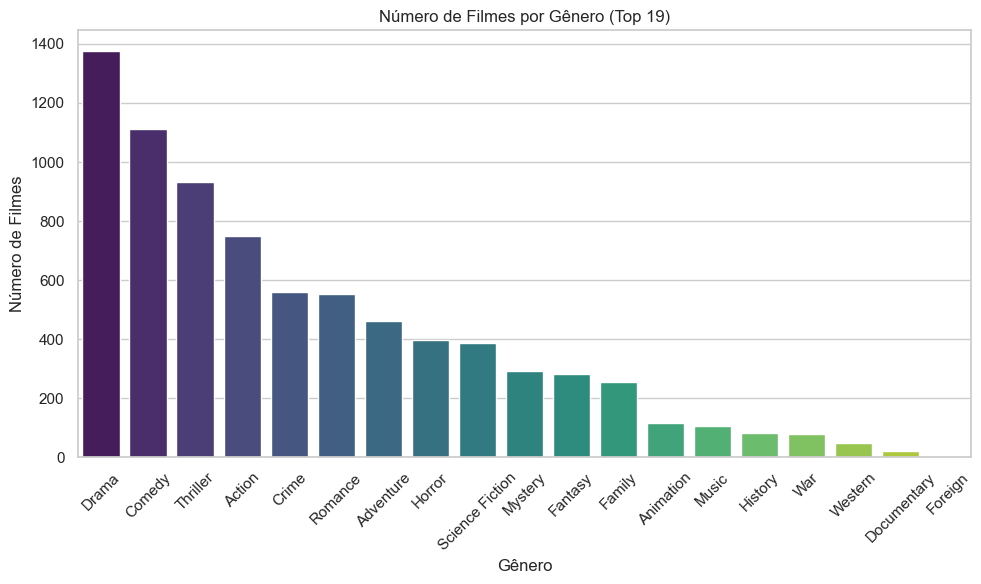

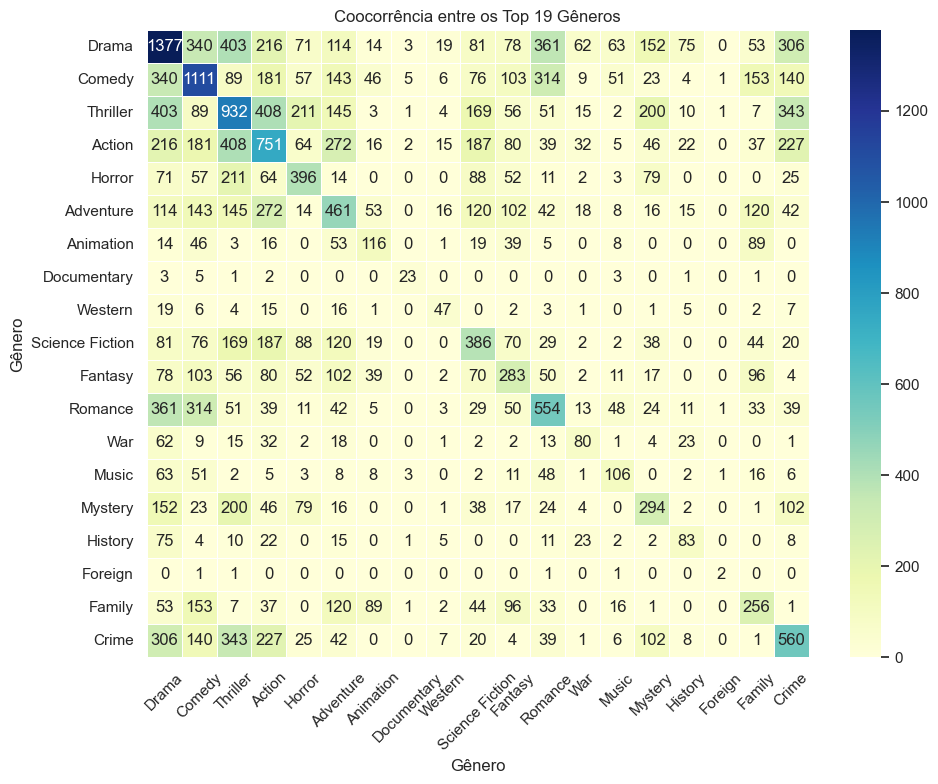

In [222]:
from collections import Counter
import itertools
import seaborn as sns
import matplotlib.pyplot as plt

# Atualizar 'genres_list' para conter apenas os top_genres
filtered_movies['selected_genres'] = filtered_movies['genres_list'].apply(lambda genres: [g for g in genres if g in top_genres])

# Remover filmes que, após a filtragem, não possuem nenhum dos top_genres (caso exista)
filtered_movies = filtered_movies[filtered_movies['selected_genres'].map(len) > 0]


genre_counts_filtered = Counter([genre for genres in filtered_movies['selected_genres'] for genre in genres])

# Convertendo para um DataFrame para melhor visualização
genre_counts_df = pd.DataFrame.from_dict(genre_counts_filtered, orient='index', columns=['Número de Filmes'])
genre_counts_df = genre_counts_df.sort_values(by='Número de Filmes', ascending=False)

print(f"\nNúmero de filmes por gênero (Top {len(top_genres)} gêneros):")
print(genre_counts_df)

# Inicializando uma matriz de coocorrência
cooccurrence_matrix = pd.DataFrame(0, index=top_genres, columns=top_genres)

# Preenchendo a matriz com as contagens de coocorrência
for genres in filtered_movies['selected_genres']:
    for genre1, genre2 in itertools.combinations(genres, 2):
        cooccurrence_matrix.at[genre1, genre2] += 1
        cooccurrence_matrix.at[genre2, genre1] += 1  # Matriz simétrica

# Adicionando a contagem de cada gênero na diagonal
for genre in top_genres:
    cooccurrence_matrix.at[genre, genre] = genre_counts_filtered[genre]

print(f"\nMatriz de Coocorrência entre os Top {len(top_genres)} Gêneros:")
print(cooccurrence_matrix)

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.barplot(x=genre_counts_df.index, y='Número de Filmes', data=genre_counts_df, palette="viridis")
plt.title(f'Número de Filmes por Gênero (Top {len(top_genres)})')
plt.xlabel('Gênero')
plt.ylabel('Número de Filmes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(cooccurrence_matrix, annot=True, fmt='d', cmap='YlGnBu', linewidths=.5)
plt.title(f'Coocorrência entre os Top {len(top_genres)} Gêneros')
plt.xlabel('Gênero')
plt.ylabel('Gênero')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [223]:
df  = filtered_movies.copy()

In [224]:
df = df.dropna(subset=['id'])
df

,adult,budget,genres,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,year,decade,ROI,profit,movieId,imdbId,tmdbId,genres_list,selected_genres
1,False,65000000.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,1995.0,1990.0,3.043035,197797249.0,2,113497,8844.0,"[Adventure, Fantasy, Family]","[Adventure, Fantasy, Family]"
3,False,16000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,1995.0,1990.0,4.090760,65452156.0,4,114885,31357.0,"[Comedy, Drama, Romance]","[Comedy, Drama, Romance]"
8,False,35000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",9091,tt0114576,en,Sudden Death,International action superstar Jean Claude Van...,5.23158,/eoWvKD60lT95Ss1MYNgVExpo5iU.jpg,"[{'name': 'Universal Pictures', 'id': 33}, {'n...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,64350171.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Terror goes into overtime.,Sudden Death,False,5.5,174.0,1995.0,1990.0,0.838576,29350171.0,9,114576,9091.0,"[Action, Adventure, Thriller]","[Action, Adventure, Thriller]"
10,False,62000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",9087,tt0112346,en,The American President,"Widowed U.S. president Andrew Shepherd, one of...",6.318445,/lymPNGLZgPHuqM29rKMGV46ANij.jpg,"[{'name': 'Columbia Pictures', 'id': 5}, {'nam...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-11-17,107879496.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Why can't the most powerful man in the world h...,The American President,False,6.5,199.0,1995.0,1990.0,0.739992,45879496.0,11,112346,9087.0,"[Comedy, Drama, Romance]","[Comedy, Drama, Romance]"
14,False,98000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",1408,tt0112760,en,Cutthroat Island,"Morgan Adams and her slave, William Shaw, are ...",7.284477,/odM9973kIv9hcjfHPp6g6BlyTIJ.jpg,"[{'name': 'Le Studio Canal+', 'id': 183}, {'na...","[{'iso_3166_1': 'FR', 'name': 'France'}, {'iso...",1995-12-22,10017322.0,119.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,The Course Has Been Set. There Is No Turning B...,Cutthroat Island,False,5.7,137.0,1995.0,1990.0,-0.897782,-87982678.0,15,112760,1408.0,"[Action, Adventure]","[Action, Adventure]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9064,False,10000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 27, 'nam...",316727,tt4094724,en,The Purge: Election Year,Two years after choosing not to kill the man w...,13.1789,/bjOJFjUffRZQpNQ9g3yvc9F6LBM.jpg,"[{'name': 'Universal Pictures', 'id': 33}, {'n...","[{'iso_3166_1': 'FR', 'name': 'France'}, {'iso...",2016-06-29,118587880.0,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Keep America great,The Purge: Election Year,False,6.1,1356.0,2016.0,2010.0,10.858788,108587880.0,160565,4094724,316727.0,"[Action, Horror, Thriller]","[Action, Horror, Thriller]"
9065,False,33000000.0,"[{'id': 35, 'name': 'Comedy'}]",316023,tt2823054,en,Mike and Dave Need Wedding Dates,"Mike and Dave are young, adventurous,

In [225]:
# df = df[df['selected_genres'].apply(len) <= 1]
# df


In [226]:
movies_metadata = df.copy()

In [227]:
movies_metadata

,adult,budget,genres,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,year,decade,ROI,profit,movieId,imdbId,tmdbId,genres_list,selected_genres
1,False,65000000.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,1995.0,1990.0,3.043035,197797249.0,2,113497,8844.0,"[Adventure, Fantasy, Family]","[Adventure, Fantasy, Family]"
3,False,16000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,1995.0,1990.0,4.090760,65452156.0,4,114885,31357.0,"[Comedy, Drama, Romance]","[Comedy, Drama, Romance]"
8,False,35000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",9091,tt0114576,en,Sudden Death,International action superstar Jean Claude Van...,5.23158,/eoWvKD60lT95Ss1MYNgVExpo5iU.jpg,"[{'name': 'Universal Pictures', 'id': 33}, {'n...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,64350171.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Terror goes into overtime.,Sudden Death,False,5.5,174.0,1995.0,1990.0,0.838576,29350171.0,9,114576,9091.0,"[Action, Adventure, Thriller]","[Action, Adventure, Thriller]"
10,False,62000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",9087,tt0112346,en,The American President,"Widowed U.S. president Andrew Shepherd, one of...",6.318445,/lymPNGLZgPHuqM29rKMGV46ANij.jpg,"[{'name': 'Columbia Pictures', 'id': 5}, {'nam...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-11-17,107879496.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Why can't the most powerful man in the world h...,The American President,False,6.5,199.0,1995.0,1990.0,0.739992,45879496.0,11,112346,9087.0,"[Comedy, Drama, Romance]","[Comedy, Drama, Romance]"
14,False,98000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",1408,tt0112760,en,Cutthroat Island,"Morgan Adams and her slave, William Shaw, are ...",7.284477,/odM9973kIv9hcjfHPp6g6BlyTIJ.jpg,"[{'name': 'Le Studio Canal+', 'id': 183}, {'na...","[{'iso_3166_1': 'FR', 'name': 'France'}, {'iso...",1995-12-22,10017322.0,119.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,The Course Has Been Set. There Is No Turning B...,Cutthroat Island,False,5.7,137.0,1995.0,1990.0,-0.897782,-87982678.0,15,112760,1408.0,"[Action, Adventure]","[Action, Adventure]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9064,False,10000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 27, 'nam...",316727,tt4094724,en,The Purge: Election Year,Two years after choosing not to kill the man w...,13.1789,/bjOJFjUffRZQpNQ9g3yvc9F6LBM.jpg,"[{'name': 'Universal Pictures', 'id': 33}, {'n...","[{'iso_3166_1': 'FR', 'name': 'France'}, {'iso...",2016-06-29,118587880.0,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Keep America great,The Purge: Election Year,False,6.1,1356.0,2016.0,2010.0,10.858788,108587880.0,160565,4094724,316727.0,"[Action, Horror, Thriller]","[Action, Horror, Thriller]"
9065,False,33000000.0,"[{'id': 35, 'name': 'Comedy'}]",316023,tt2823054,en,Mike and Dave Need Wedding Dates,"Mike and Dave are young, adventurous,

# 3. Seleção de Features

Nesta seção, abordaremos a seleção e engenharia de atributos que são cruciais para a análise de clusterização. A engenharia de atributos visa criar novas variáveis a partir das existentes para capturar informações adicionais que podem melhorar a performance dos algoritmos de clusterização. Em seguida, selecionaremos as variáveis mais relevantes para a análise e, por fim, aplicaremos técnicas de redução de dimensionalidade para otimizar o conjunto de dados.

## 3.1. Engenharia de Atributos

A engenharia de atributos envolve a criação de novas features que podem capturar padrões mais complexos nos dados. A seguir, implementaremos diversas transformações e criações de novas variáveis com base no dataset de filmes.

### 3.1.1. Log do Orçamento

Transformar o orçamento (`budget`) para uma escala logarítmica pode ajudar a lidar com assimetrias na distribuição, tornando a variável mais adequada para modelagem.


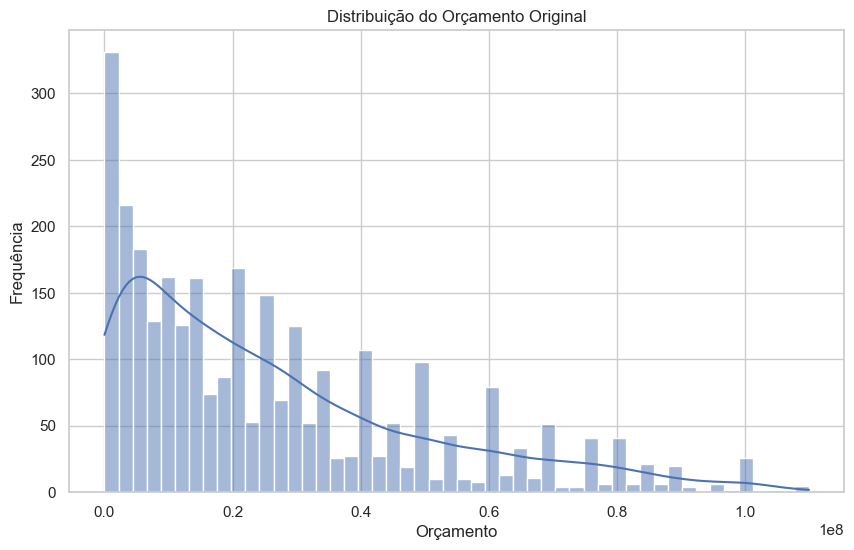

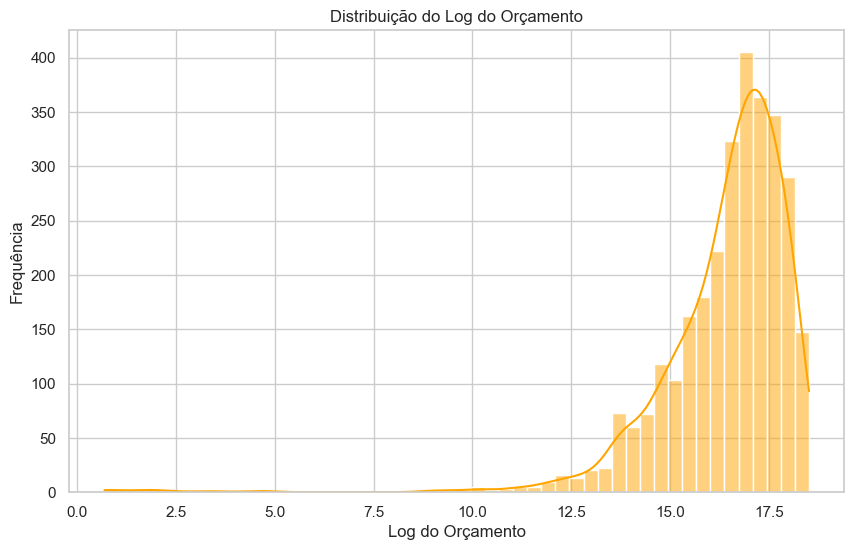

In [228]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Verificando a distribuição original do orçamento
plt.figure(figsize=(10, 6))
sns.histplot(movies_metadata['budget'], bins=50, kde=True)
plt.title('Distribuição do Orçamento Original')
plt.xlabel('Orçamento')
plt.ylabel('Frequência')
plt.show()

# Adicionando uma nova coluna com o log do orçamento
# Adicionamos 1 para evitar log(0)
movies_metadata['budget_log'] = np.log1p(movies_metadata['budget'])

# Verificando a distribuição após a transformação logarítmica
plt.figure(figsize=(10, 6))
sns.histplot(movies_metadata['budget_log'], bins=50, kde=True, color='orange')
plt.title('Distribuição do Log do Orçamento')
plt.xlabel('Log do Orçamento')
plt.ylabel('Frequência')
plt.show()

### 3.1.2. Relação Receita/Orçamento (ROI)

O Retorno sobre Investimento (ROI) já está presente no dataset como `ROI`. Podemos criar variações dessa métrica, como categorizar o ROI em faixas que indicam a margem do investimento.

### 3.1.3. Lucro Categorizado

Vamos categorizar o lucro (`profit`) em faixas como "Muito lucrativo", "Pouco lucrativo" e "Prejuízo" para facilitar a análise.


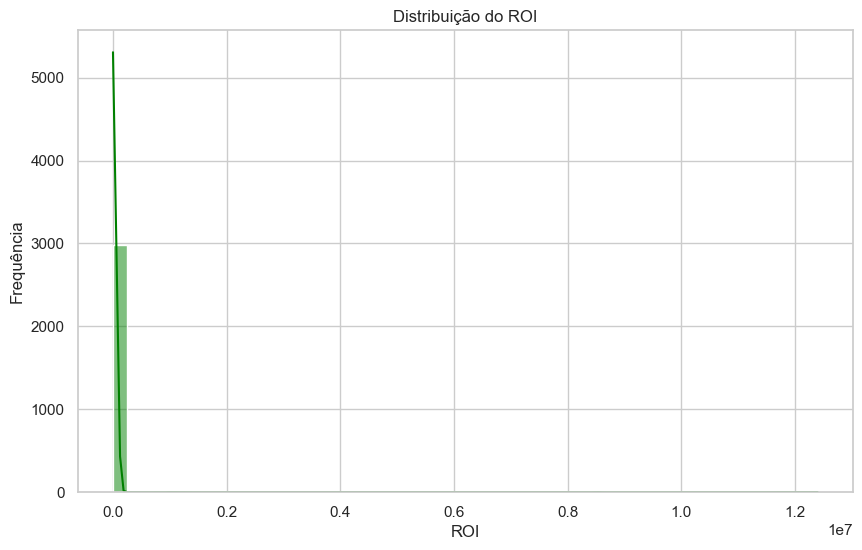

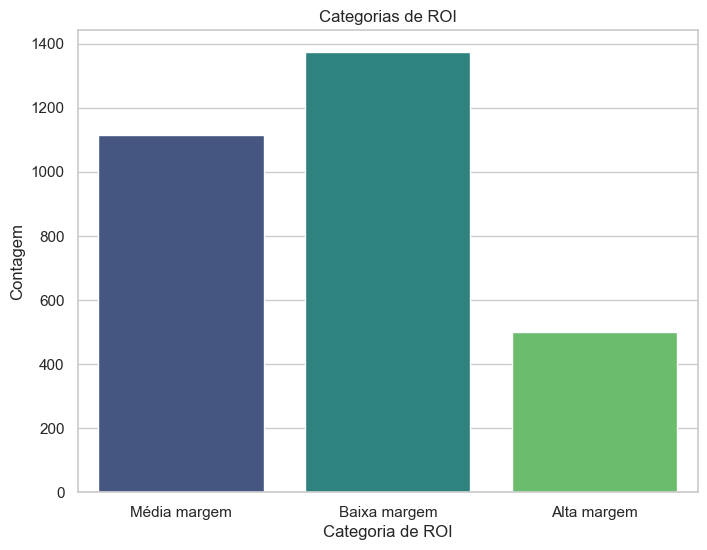

In [229]:
# Visualizando a distribuição do ROI
plt.figure(figsize=(10, 6))
sns.histplot(movies_metadata['ROI'], bins=50, kde=True, color='green')
plt.title('Distribuição do ROI')
plt.xlabel('ROI')
plt.ylabel('Frequência')
plt.show()

# Criando categorias de ROI
def categorize_ROI(roi):
    if roi < 1:
        return 'Baixa margem'
    elif 1 <= roi < 5:
        return 'Média margem'
    else:
        return 'Alta margem'

movies_metadata['ROI_category'] = movies_metadata['ROI'].apply(categorize_ROI)

# Visualizando a distribuição das categorias de ROI
plt.figure(figsize=(8, 6))
sns.countplot(x='ROI_category', data=movies_metadata, palette='viridis')
plt.title('Categorias de ROI')
plt.xlabel('Categoria de ROI')
plt.ylabel('Contagem')
plt.show()

### 3.1.4. Orçamento Ajustado pela Década

Ajustar o orçamento para valores corrigidos pela inflação usando o atributo `decade` pode proporcionar uma visão mais precisa do investimento real ao longo do tempo.


[1995. 1996. 1976. 1992. 1994. 1993. 1982. 1937. 1940. 1969. 1970. 1968.
 1988. 1964. 1997. 1952. 1951. 1961. 1958. 1954. 1934. 1959. 1960. 1963.
 1942. 1941. 1953. 1939. 1950. 1946. 1945. 1955. 1938. 1944. 1935. 1932.
 1971. 1981. 1973. 1979. 1967. 1987. 1986. 1989. 1991. 1990. 1980. 1975.
 1957. 1977. 1984. 1974. 1948. 1962. 1956. 1978. 1983. 1985. 1998. 1929.
 1966. 1972. 1933. 1999. 1931. 1965. 2000. 1921. 1936. 1925. 2001. 2002.
 1949. 2003. 2004. 1924. 2005. 2006. 1943. 2007. 2008. 1916. 2009. 2010.
 2011. 2013. 2012. 2014. 2015. 2016.]


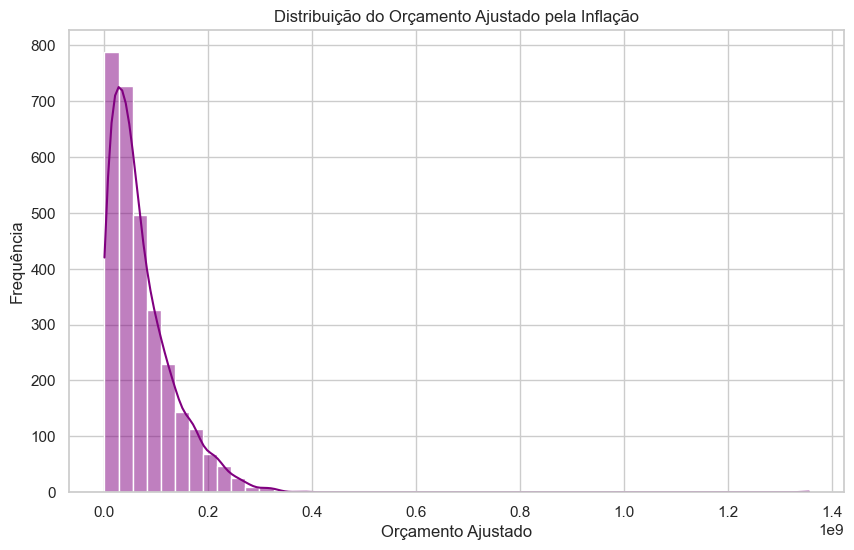

In [230]:
# Verificando os anos disponíveis
print(movies_metadata['year'].unique())

# Supondo que temos uma inflação média anual de 5%, ajustaremos o orçamento para a década de 2020
def adjust_budget_for_inflation(row, base_year=2020, inflation_rate=0.05):
    years_diff = base_year - row['year']
    adjusted_budget = row['budget'] * ((1 + inflation_rate) ** years_diff)
    return adjusted_budget

# Aplicando a função para ajustar o orçamento
movies_metadata['budget_adjusted'] = movies_metadata.apply(adjust_budget_for_inflation, axis=1)

# Verificando a distribuição do orçamento ajustado
plt.figure(figsize=(10, 6))
sns.histplot(movies_metadata['budget_adjusted'], bins=50, kde=True, color='purple')
plt.title('Distribuição do Orçamento Ajustado pela Inflação')
plt.xlabel('Orçamento Ajustado')
plt.ylabel('Frequência')
plt.show()

### 3.1.5. Mês de Lançamento

Extrair o mês da coluna `release_date` pode ajudar a identificar padrões sazonais nos lançamentos de filmes.

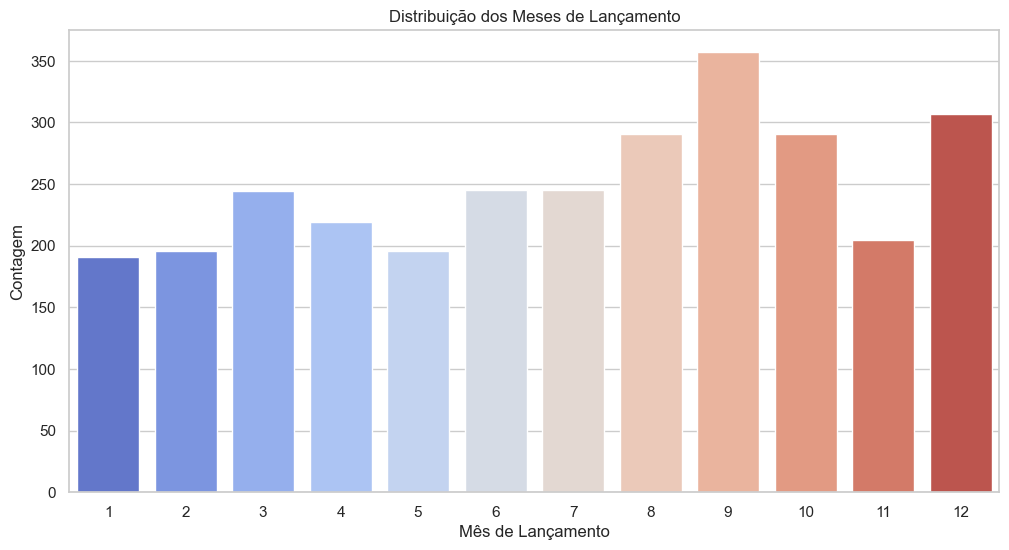

In [231]:
# Convertendo a coluna release_date para datetime
movies_metadata['release_date'] = pd.to_datetime(movies_metadata['release_date'], errors='coerce')

# Extraindo o mês de lançamento
movies_metadata['release_month'] = movies_metadata['release_date'].dt.month

# Verificando a distribuição dos meses de lançamento
plt.figure(figsize=(12, 6))
sns.countplot(x='release_month', data=movies_metadata, palette='coolwarm')
plt.title('Distribuição dos Meses de Lançamento')
plt.xlabel('Mês de Lançamento')
plt.ylabel('Contagem')
plt.show()

### 3.1.6. Estação do Ano

Classificar o mês de lançamento em estações (primavera, verão, outono, inverno) pode revelar padrões sazonais adicionais.

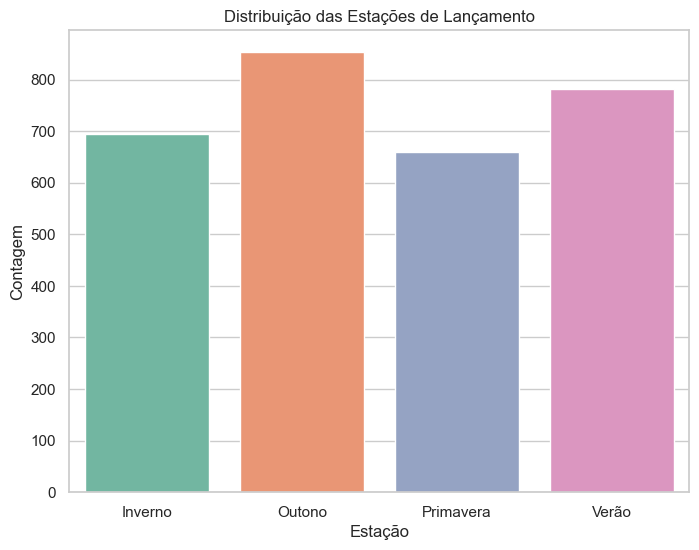

In [232]:
# Função para mapear meses para estações
def get_season(month):
    if month in [12, 1, 2]:
        return 'Inverno'
    elif month in [3, 4, 5]:
        return 'Primavera'
    elif month in [6, 7, 8]:
        return 'Verão'
    elif month in [9, 10, 11]:
        return 'Outono'
    else:
        return 'Desconhecido'

# Aplicando a função para criar a coluna de estação
movies_metadata['release_season'] = movies_metadata['release_month'].apply(get_season)

# Verificando a distribuição das estações de lançamento
plt.figure(figsize=(8, 6))
sns.countplot(x='release_season', data=movies_metadata, palette='Set2')
plt.title('Distribuição das Estações de Lançamento')
plt.xlabel('Estação')
plt.ylabel('Contagem')
plt.show()


### 3.1.7. Dia da Semana de Lançamento

Extrair o dia da semana da coluna `release_date` pode destacar padrões de lançamentos.

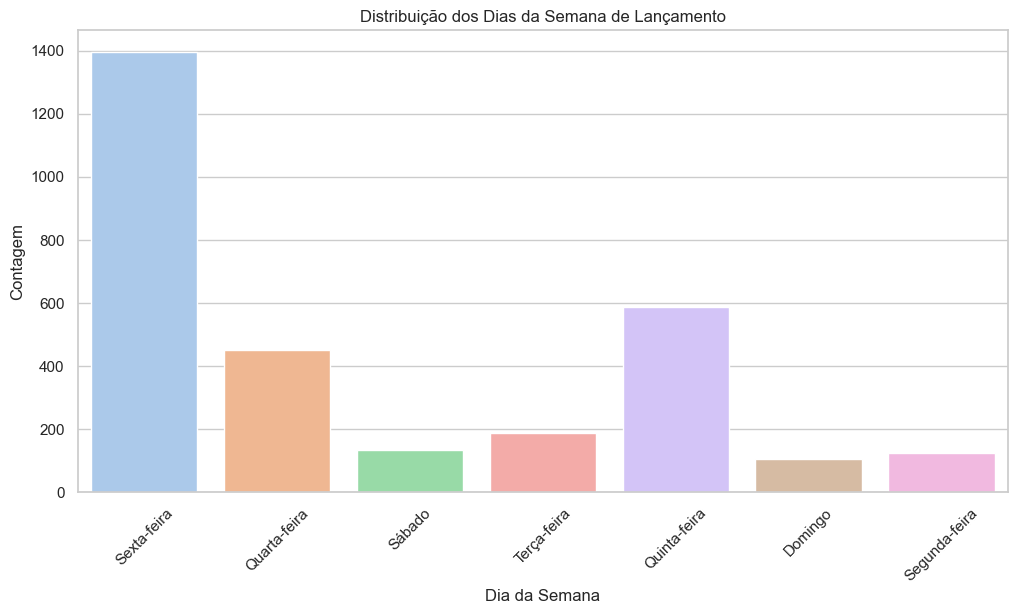

In [233]:
# Extraindo o dia da semana
movies_metadata['release_day_of_week'] = movies_metadata['release_date'].dt.dayofweek  # 0=Monday, 6=Sunday

# Mapeando os números para os nomes dos dias
day_mapping = {0: 'Segunda-feira', 1: 'Terça-feira', 2: 'Quarta-feira',
               3: 'Quinta-feira', 4: 'Sexta-feira', 5: 'Sábado', 6: 'Domingo'}
movies_metadata['release_day'] = movies_metadata['release_day_of_week'].map(day_mapping)

# Verificando a distribuição dos dias de lançamento
plt.figure(figsize=(12, 6))
sns.countplot(x='release_day', data=movies_metadata, palette='pastel')
plt.title('Distribuição dos Dias da Semana de Lançamento')
plt.xlabel('Dia da Semana')
plt.ylabel('Contagem')
plt.xticks(rotation=45)
plt.show()

### 3.1.8. Idade do Filme

Calcular a diferença entre o ano atual (2024) e o ano de lançamento (`year`) para determinar a idade do filme.

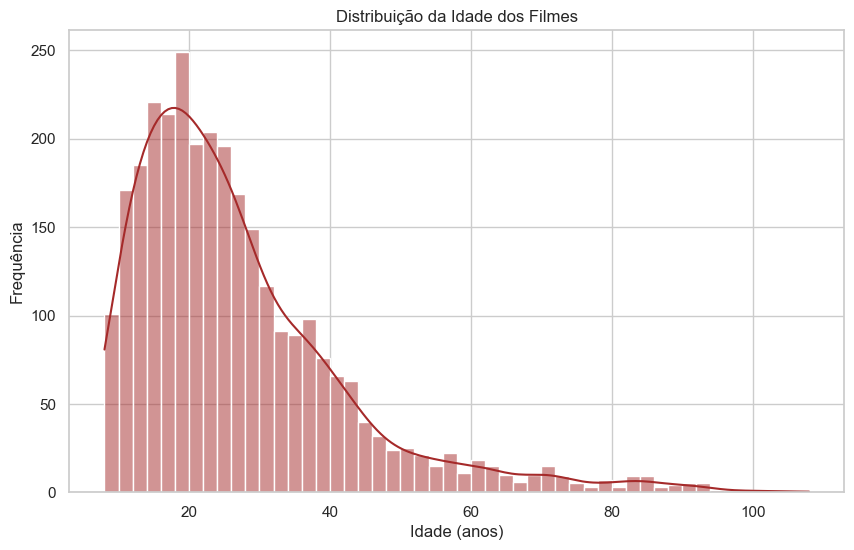

In [234]:
# Definindo o ano atual
current_year = 2024

# Calculando a idade do filme
movies_metadata['age'] = current_year - movies_metadata['year']

# Verificando a distribuição da idade dos filmes
plt.figure(figsize=(10, 6))
sns.histplot(movies_metadata['age'], bins=50, kde=True, color='brown')
plt.title('Distribuição da Idade dos Filmes')
plt.xlabel('Idade (anos)')
plt.ylabel('Frequência')
plt.show()

### 3.1.9. Popularidade ao Longo do Tempo

Criar uma métrica de popularidade ajustada pela idade do filme pode fornecer insights sobre como a popularidade decai ou se mantém ao longo do tempo.

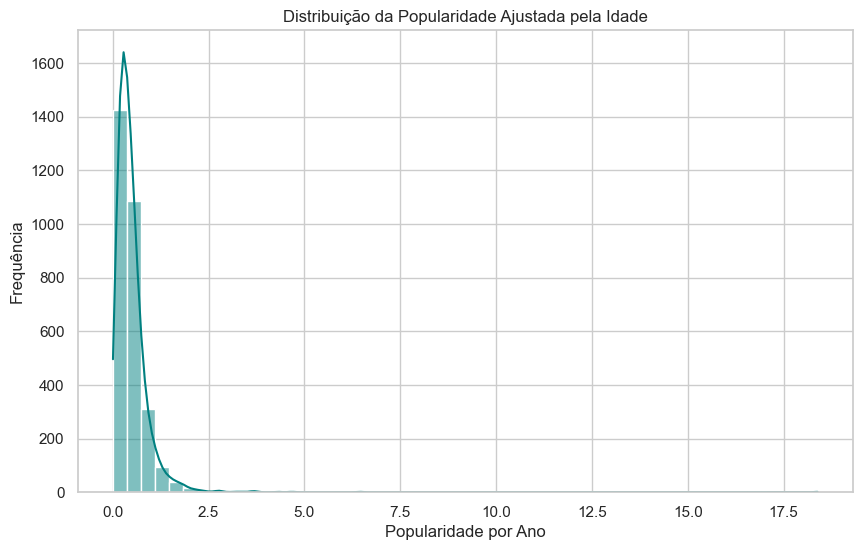

In [235]:
# Convertendo a coluna 'popularity' para numérica
movies_metadata['popularity'] = pd.to_numeric(movies_metadata['popularity'], errors='coerce')

# Substituindo valores nulos em 'popularity' (caso existam) com um valor padrão (opcional, dependendo do contexto)
movies_metadata['popularity'].fillna(0, inplace=True)

# Evitando divisão por zero substituindo idade 0 por 1
movies_metadata['age_adjusted'] = movies_metadata['age'].replace(0, 1)

# Calculando a popularidade ajustada
movies_metadata['popularity_per_year'] = movies_metadata['popularity'] / movies_metadata['age_adjusted']

# Verificando a distribuição da popularidade ajustada
plt.figure(figsize=(10, 6))
sns.histplot(movies_metadata['popularity_per_year'], bins=50, kde=True, color='teal')
plt.title('Distribuição da Popularidade Ajustada pela Idade')
plt.xlabel('Popularidade por Ano')
plt.ylabel('Frequência')
plt.show()

### 3.1.10. Número de Empresas de Produção

Contar quantas empresas estão listadas em `production_companies` pode indicar a escala de produção de um filme.


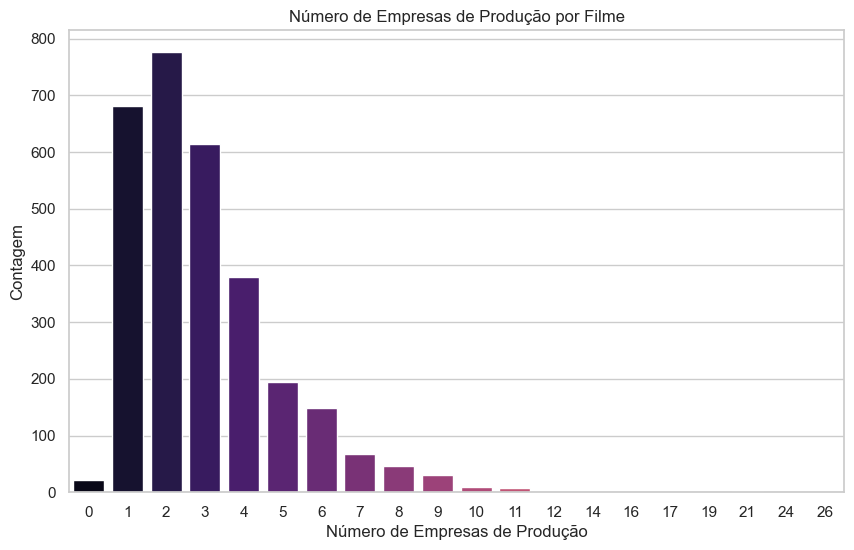

In [236]:
import ast

# Função para contar o número de empresas de produção
def count_production_companies(companies_str):
    try:
        companies = ast.literal_eval(companies_str)
        return len(companies)
    except (ValueError, SyntaxError, TypeError):
        return 0

# Aplicando a função
movies_metadata['num_production_companies'] = movies_metadata['production_companies'].apply(count_production_companies)

# Verificando a distribuição do número de empresas de produção
plt.figure(figsize=(10, 6))
sns.countplot(x='num_production_companies', data=movies_metadata, palette='magma')
plt.title('Número de Empresas de Produção por Filme')
plt.xlabel('Número de Empresas de Produção')
plt.ylabel('Contagem')
plt.show()

### 3.1.11. Número de Países de Produção

Contar quantos países estão listados em `production_countries` pode refletir a internacionalização da produção de um filme.


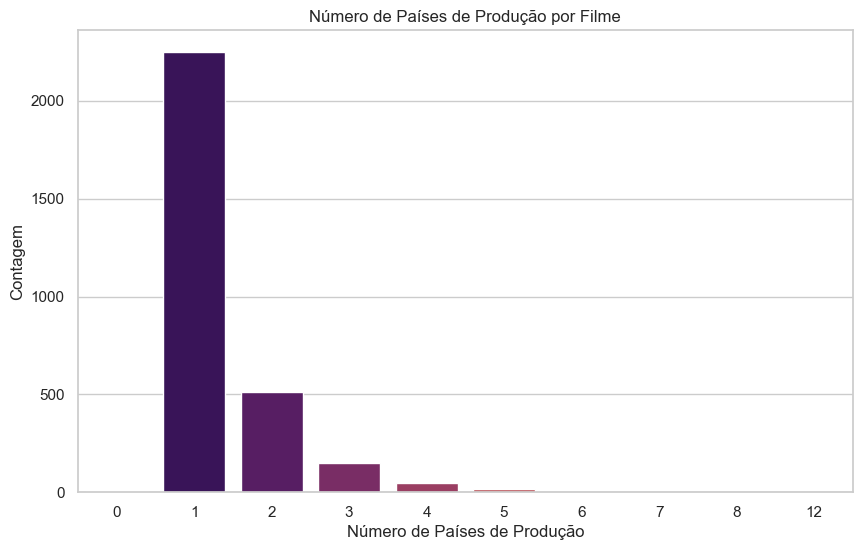

In [237]:
# Função para contar o número de países de produção
def count_production_countries(countries_str):
    try:
        countries = ast.literal_eval(countries_str)
        return len(countries)
    except (ValueError, SyntaxError, TypeError):
        return 0

# Aplicando a função
movies_metadata['num_production_countries'] = movies_metadata['production_countries'].apply(count_production_countries)

# Verificando a distribuição do número de países de produção
plt.figure(figsize=(10, 6))
sns.countplot(x='num_production_countries', data=movies_metadata, palette='inferno')
plt.title('Número de Países de Produção por Filme')
plt.xlabel('Número de Países de Produção')
plt.ylabel('Contagem')
plt.show()


### 3.1.12. Diversidade Linguística

Contar o número de idiomas listados em `spoken_languages` pode indicar a diversidade linguística do filme.

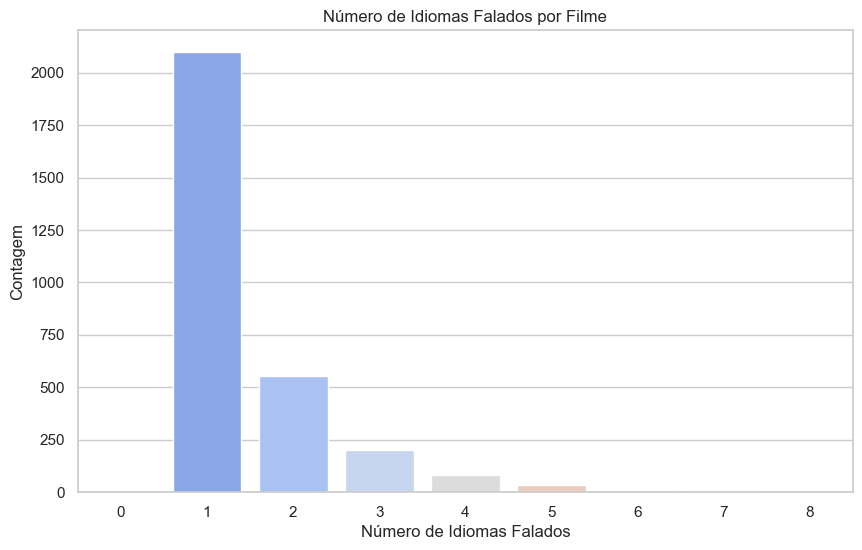

In [238]:
# Função para contar o número de idiomas falados
def count_spoken_languages(languages_str):
    try:
        languages = ast.literal_eval(languages_str)
        return len(languages)
    except (ValueError, SyntaxError, TypeError):
        return 0

# Aplicando a função
movies_metadata['num_spoken_languages'] = movies_metadata['spoken_languages'].apply(count_spoken_languages)

# Verificando a distribuição da diversidade linguística
plt.figure(figsize=(10, 6))
sns.countplot(x='num_spoken_languages', data=movies_metadata, palette='coolwarm')
plt.title('Número de Idiomas Falados por Filme')
plt.xlabel('Número de Idiomas Falados')
plt.ylabel('Contagem')
plt.show()

### 3.1.13. Idioma Principal

Transformar `original_language` em variáveis binárias para os idiomas mais comuns pode capturar preferências linguísticas nos filmes.



In [239]:
# Identificando os idiomas mais comuns
top_languages = movies_metadata['original_language'].value_counts().nlargest(5).index.tolist()
print(f"Top 5 idiomas mais comuns: {top_languages}")

# Criando variáveis binárias para os idiomas mais comuns
for lang in top_languages:
    movies_metadata[f'language_{lang}'] = (movies_metadata['original_language'] == lang).astype(int)

# Criando uma variável binária para 'outros' idiomas
movies_metadata['language_other'] = (~movies_metadata['original_language'].isin(top_languages)).astype(int)

# Verificando as novas colunas de idiomas
movies_metadata[[f'language_{lang}' for lang in top_languages] + ['language_other']].head()


Top 5 idiomas mais comuns: ['en', 'fr', 'ja', 'es', 'de']


,language_en,language_fr,language_ja,language_es,language_de,language_other
1,1,0,0,0,0,0
3,1,0,0,0,0,0
8,1,0,0,0,0,0
10,1,0,0,0,0,0
14,1,0,0,0,0,0


### 3.1.14. Classificação por Década

Criar faixas temporais mais amplas, como "Clássicos" (antes de 1980), "Anos 80/90" e "Contemporâneos" (2000+), pode ajudar na análise temporal dos filmes.

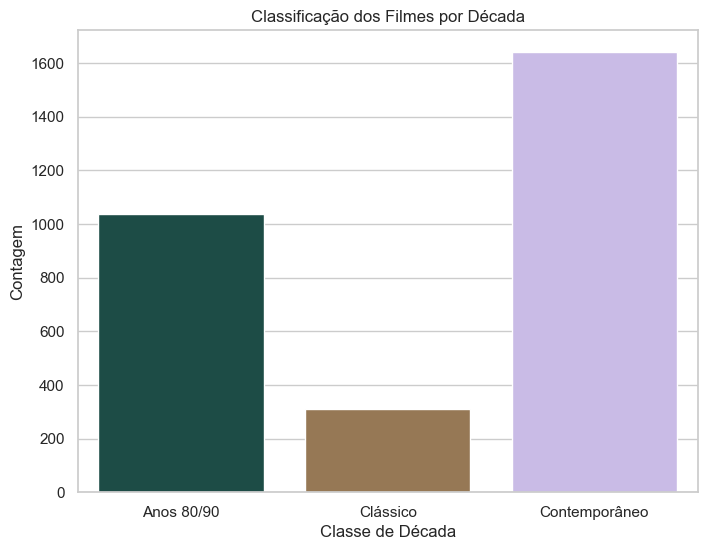

In [240]:
# Função para classificar filmes por década
def classify_decade(year):
    if year < 1980:
        return 'Clássico'
    elif 1980 <= year < 2000:
        return 'Anos 80/90'
    else:
        return 'Contemporâneo'

# Aplicando a função
movies_metadata['decade_class'] = movies_metadata['year'].apply(classify_decade)

# Verificando a distribuição das classes de década
plt.figure(figsize=(8, 6))
sns.countplot(x='decade_class', data=movies_metadata, palette='cubehelix')
plt.title('Classificação dos Filmes por Década')
plt.xlabel('Classe de Década')
plt.ylabel('Contagem')
plt.show()

### 3.1.15. Classificação por Duração

Categorizar filmes com base na duração (`runtime`) em "Muito Curto", "Curto", "Médio", "Longo" e "Muito Longo" pode ajudar a identificar padrões relacionados à duração.

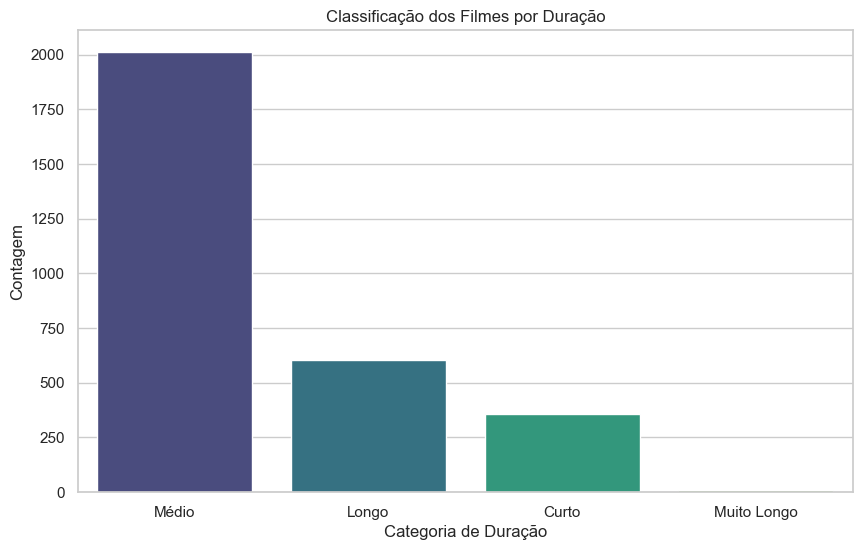

In [241]:
# Definindo as faixas de duração
def categorize_runtime(runtime):
    if runtime < 60:
        return 'Muito Curto'
    elif 60 <= runtime < 90:
        return 'Curto'
    elif 90 <= runtime < 120:
        return 'Médio'
    elif 120 <= runtime < 150:
        return 'Longo'
    else:
        return 'Muito Longo'

# Aplicando a função
movies_metadata['runtime_category'] = movies_metadata['runtime'].apply(categorize_runtime)

# Verificando a distribuição das categorias de duração
plt.figure(figsize=(10, 6))
sns.countplot(x='runtime_category', data=movies_metadata, palette='viridis')
plt.title('Classificação dos Filmes por Duração')
plt.xlabel('Categoria de Duração')
plt.ylabel('Contagem')
plt.show()

### 3.1.16. Comprimento do Texto

Calcular o número de palavras no título e no resumo (`overview`) pode fornecer insights sobre a complexidade e detalhes dos filmes.


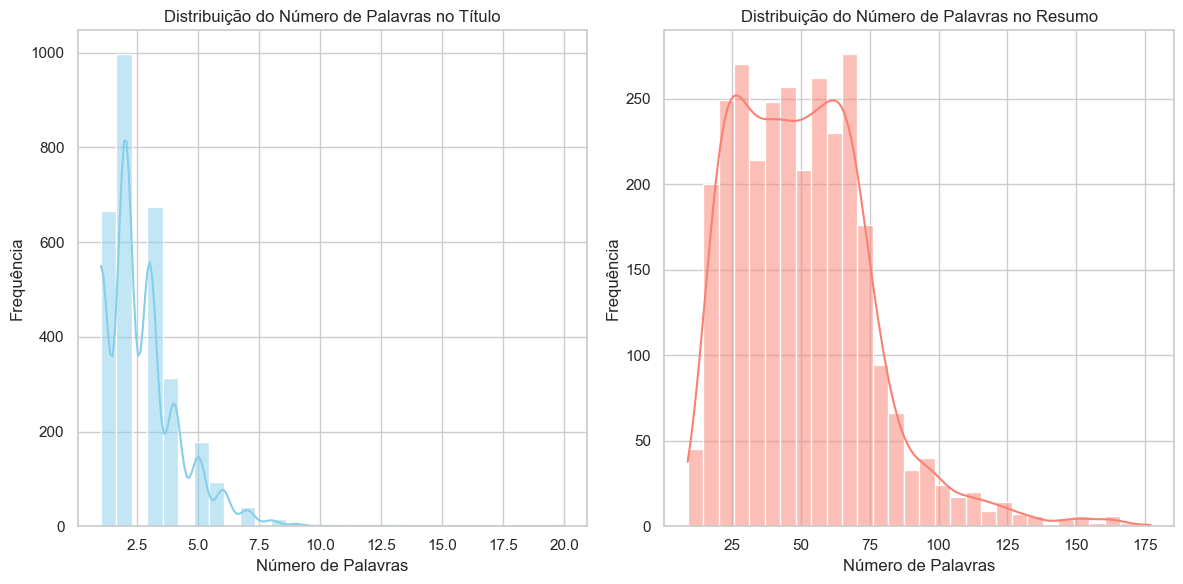

In [242]:
# Função para contar palavras
def count_words(text):
    if isinstance(text, str):
        return len(text.split())
    else:
        return 0

# Contando palavras no título
movies_metadata['title_word_count'] = movies_metadata['title'].apply(count_words)

# Contando palavras no resumo
movies_metadata['overview_word_count'] = movies_metadata['overview'].apply(count_words)

# Verificando a distribuição dos comprimentos do texto
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(movies_metadata['title_word_count'], bins=30, kde=True, color='skyblue')
plt.title('Distribuição do Número de Palavras no Título')
plt.xlabel('Número de Palavras')
plt.ylabel('Frequência')

plt.subplot(1, 2, 2)
sns.histplot(movies_metadata['overview_word_count'], bins=30, kde=True, color='salmon')
plt.title('Distribuição do Número de Palavras no Resumo')
plt.xlabel('Número de Palavras')
plt.ylabel('Frequência')

plt.tight_layout()
plt.show()

### 3.1.17. Presença de Palavras-Chave

Criar variáveis binárias que indiquem se palavras específicas estão presentes no título ou no resumo, como "action", "thriller", "animated", etc.

In [243]:
movies_metadata.columns

Index(['adult', 'budget', 'genres', 'id', 'imdb_id', 'original_language', 'original_title', 'overview', 'popularity', 'poster_path', 'production_companies', 'production_countries', 'release_date', 'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'title', 'video', 'vote_average', 'vote_count', 'year', 'decade', 'ROI', 'profit', 'movieId', 'imdbId', 'tmdbId', 'genres_list', 'selected_genres', 'budget_log', 'ROI_category', 'budget_adjusted', 'release_month', 'release_season', 'release_day_of_week', 'release_day', 'age', 'age_adjusted', 'popularity_per_year', 'num_production_companies', 'num_production_countries', 'num_spoken_languages', 'language_en', 'language_fr', 'language_ja', 'language_es', 'language_de', 'language_other', 'decade_class', 'runtime_category', 'title_word_count', 'overview_word_count'], dtype='object')

In [244]:
from collections import Counter
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import pandas as pd

# Função para tokenização e limpeza
def tokenize_and_clean(text):
    if not isinstance(text, str):
        return []
    tokens = text.lower().replace('-', ' ').split()
    tokens = [word for word in tokens if word not in ENGLISH_STOP_WORDS and len(word) > 2]
    return tokens

# Contando palavras globalmente em títulos e resumos
global_title_counts = Counter()
global_overview_counts = Counter()

# Processando títulos
titles_texts = movies_metadata['title'].dropna().apply(tokenize_and_clean).tolist()
for tokens in titles_texts:
    global_title_counts.update(tokens)

# Processando resumos
overviews_texts = movies_metadata['overview'].dropna().apply(tokenize_and_clean).tolist()
for tokens in overviews_texts:
    global_overview_counts.update(tokens)

# Gerando stopwords dinâmicas para títulos e resumos
threshold = 0.3  # Palavras que aparecem em mais de 30% dos textos são tratadas como stopwords
dynamic_stopwords_title = {word for word, count in global_title_counts.items() if count / len(titles_texts) > threshold}
dynamic_stopwords_overview = {word for word, count in global_overview_counts.items() if count / len(overviews_texts) > threshold}

# Identificando palavras-chave por gênero
keywords_per_genre = {}

for genre in set(genre for genres in movies_metadata['selected_genres'] if genres for genre in genres):
    genre_texts = movies_metadata[movies_metadata['selected_genres'].apply(lambda x: genre in x)]
    
    # Títulos
    titles = genre_texts['title'].dropna().apply(tokenize_and_clean)
    title_words = [word for text in titles for word in text if word not in dynamic_stopwords_title]
    title_word_counts = Counter(title_words)
    top_title_words = [word for word, _ in title_word_counts.most_common(5)]
    
    # Resumos
    overviews = genre_texts['overview'].dropna().apply(tokenize_and_clean)
    overview_words = [word for text in overviews for word in text if word not in dynamic_stopwords_overview]
    overview_word_counts = Counter(overview_words)
    top_overview_words = [word for word, _ in overview_word_counts.most_common(5)]
    
    # Salvando resultados
    keywords_per_genre[genre] = {
        "title_words": top_title_words,
        "overview_words": top_overview_words
    }

# Criando colunas no DataFrame
all_title_words = {f"title_word_{i}": word for i, word in enumerate(set(word for k in keywords_per_genre.values() for word in k['title_words']), 1)}
all_overview_words = {f"overview_word_{i}": word for i, word in enumerate(set(word for k in keywords_per_genre.values() for word in k['overview_words']), 1)}

for column, word in all_title_words.items():
    movies_metadata[column] = movies_metadata['title'].apply(lambda x: 1 if word in tokenize_and_clean(x) else 0)

for column, word in all_overview_words.items():
    movies_metadata[column] = movies_metadata['overview'].apply(lambda x: 1 if word in tokenize_and_clean(x) else 0)

In [245]:
movies_metadata.head(5)

,adult,budget,genres,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,year,decade,ROI,profit,movieId,imdbId,tmdbId,genres_list,selected_genres,budget_log,ROI_category,budget_adjusted,release_month,release_season,release_day_of_week,release_day,age,age_adjusted,popularity_per_year,num_production_companies,num_production_countries,num_spoken_languages,language_en,language_fr,language_ja,language_es,language_de,language_other,decade_class,runtime_category,title_word_count,overview_word_count,title_word_1,title_word_2,title_word_3,title_word_4,title_word_5,title_word_6,title_word_7,title_word_8,title_word_9,title_word_10,title_word_11,title_word_12,title_word_13,title_word_14,title_word_15,title_word_16,title_word_17,title_word_18,title_word_19,title_word_20,title_word_21,title_word_22,title_word_23,title_word_24,title_word_25,title_word_26,title_word_27,title_word_28,title_word_29,title_word_30,title_word_31,title_word_32,title_word_33,title_word_34,title_word_35,title_word_36,title_word_37,title_word_38,title_word_39,title_word_40,title_word_41,title_word_42,title_word_43,title_word_44,title_word_45,title_word_46,title_word_47,title_word_48,title_word_49,title_word_50,title_word_51,title_word_52,title_word_53,title_word_54,title_word_55,title_word_56,title_word_57,title_word_58,overview_word_1,overview_word_2,overview_word_3,overview_word_4,overview_word_5,overview_word_6,overview_word_7,overview_word_8,overview_word_9,overview_word_10,overview_word_11,overview_word_12,overview_word_13,overview_word_14,overview_word_15,overview_word_16,overview_word_17,overview_word_18,overview_word_19,overview_word_20,overview_word_21,overview_word_22,overview_word_23,overview_word_24,overview_word_25,overview_word_26,overview_word_27,overview_word_28,overview_word_29,overview_word_30,overview_word_31,overview_word_32,overview_word_33,overview_word_34,overview_word_35,overview_word_36,overview_word_37
1,False,65000000.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,1995.0,1990.0,3.043035,197797249.0,2,113497,8844.0,"[Adventure, Fantasy, Family]","[Adventure, Fantasy, Family]",17.989898,Média margem,2.201131e+08,12,Inverno,4,Sexta-feira,29.0,29.0,0.586743,3,1,2,1,0,0,0,0,0,Anos 80/90,Médio,1,67,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,False,16000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,1995.0,1990.0,4.090760,65452156.0,4,114885,31357.0,"[Comedy, Drama, Romance]","[Comedy, Drama, Romance]",16.588099,Média margem,5.418168e+07,12,Inverno,4,Sexta-feira,29.0,29.0,0.133086,1,1,1,1,0,0,0,0,0,Anos 80/90,Longo,3,45,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,False,35000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",9091,tt0114576,en,Sudden Death,International action superstar Jean Claude Van...,5.231580,

### 3.1.18. Análise de Sentimentos do Resumo

Determinar o sentimento predominante do resumo (`overview`) usando ferramentas de processamento de linguagem natural (NLP).


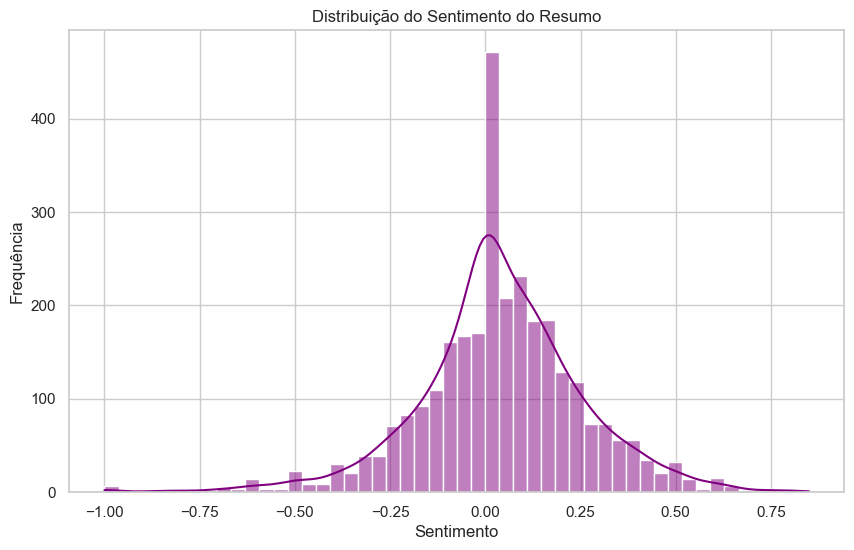

In [246]:
from textblob import TextBlob

# Função para calcular o sentimento do texto
def get_sentiment(text):
    if isinstance(text, str):
        blob = TextBlob(text)
        return blob.sentiment.polarity  # Valor entre -1 (negativo) e 1 (positivo)
    else:
        return 0

# Calculando o sentimento do resumo
movies_metadata['overview_sentiment'] = movies_metadata['overview'].apply(get_sentiment)

# Verificando a distribuição do sentimento
plt.figure(figsize=(10, 6))
sns.histplot(movies_metadata['overview_sentiment'], bins=50, kde=True, color='purple')
plt.title('Distribuição do Sentimento do Resumo')
plt.xlabel('Sentimento')
plt.ylabel('Frequência')
plt.show()

### 3.1.19. Tópicos Latentes (LDA)

Usar análise de tópicos em textos (como Latent Dirichlet Allocation) para identificar padrões latentes no título e no resumo.

In [247]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Combinar título e resumo
movies_metadata['combined_text'] = movies_metadata['title'] + ' ' + movies_metadata['overview'].fillna('')

# Vetorização do texto
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
text_vector = vectorizer.fit_transform(movies_metadata['combined_text'])

# Definindo o número de tópicos
num_topics = 30

# Aplicando LDA
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(text_vector)

# Função para obter os tópicos
def get_topics(model, vectorizer, top_n=5):
    topics = {}
    for idx, topic in enumerate(model.components_):
        top_features = [vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-top_n - 1:-1]]
        topics[f'Topic_{idx}'] = top_features
    return topics

# Identificando tópicos no texto
topic_distributions = lda.transform(text_vector)

# Adicionando colunas de tópicos no DataFrame
for i in range(num_topics):
    movies_metadata[f'topic_{i}'] = (topic_distributions[:, i] > 0.1).astype(int)  # Threshold de 0.1 para identificar relevância

In [248]:
movies_metadata

,adult,budget,genres,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,year,decade,ROI,profit,movieId,imdbId,tmdbId,genres_list,selected_genres,budget_log,ROI_category,budget_adjusted,release_month,release_season,release_day_of_week,release_day,age,age_adjusted,popularity_per_year,num_production_companies,num_production_countries,num_spoken_languages,language_en,language_fr,language_ja,language_es,language_de,language_other,decade_class,runtime_category,title_word_count,overview_word_count,title_word_1,title_word_2,title_word_3,title_word_4,title_word_5,title_word_6,title_word_7,title_word_8,title_word_9,title_word_10,title_word_11,title_word_12,title_word_13,title_word_14,title_word_15,title_word_16,title_word_17,title_word_18,title_word_19,title_word_20,title_word_21,title_word_22,title_word_23,title_word_24,title_word_25,title_word_26,title_word_27,title_word_28,title_word_29,title_word_30,title_word_31,title_word_32,title_word_33,title_word_34,title_word_35,title_word_36,title_word_37,title_word_38,title_word_39,title_word_40,title_word_41,title_word_42,title_word_43,title_word_44,title_word_45,title_word_46,title_word_47,title_word_48,title_word_49,title_word_50,title_word_51,title_word_52,title_word_53,title_word_54,title_word_55,title_word_56,title_word_57,title_word_58,overview_word_1,overview_word_2,overview_word_3,overview_word_4,overview_word_5,overview_word_6,overview_word_7,overview_word_8,overview_word_9,overview_word_10,overview_word_11,overview_word_12,overview_word_13,overview_word_14,overview_word_15,overview_word_16,overview_word_17,overview_word_18,overview_word_19,overview_word_20,overview_word_21,overview_word_22,overview_word_23,overview_word_24,overview_word_25,overview_word_26,overview_word_27,overview_word_28,overview_word_29,overview_word_30,overview_word_31,overview_word_32,overview_word_33,overview_word_34,overview_word_35,overview_word_36,overview_word_37,overview_sentiment,combined_text,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,topic_25,topic_26,topic_27,topic_28,topic_29
1,False,65000000.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,1995.0,1990.0,3.043035,197797249.0,2,113497,8844.0,"[Adventure, Fantasy, Family]","[Adventure, Fantasy, Family]",17.989898,Média margem,2.201131e+08,12,Inverno,4,Sexta-feira,29.0,29.0,0.586743,3,1,2,1,0,0,0,0,0,Anos 80/90,Médio,1,67,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,-0.218750,Jumanji When siblings Judy and Peter discover ...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,False,16000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,1995.0,1990.0,4.090760,65452156.0,4,114885,31357.0,"[Comedy, Drama, Romance]","[Comedy, Drama, Romance]",16.588099,Média margem,5.418168e+07,12,Inverno,4,Sexta-fei

In [249]:
df = movies_metadata.copy()

## 3.2 Transformação de Variáveis para Formato Numérico

Para que os algoritmos de clusterização possam processar adequadamente os dados, todas as variáveis devem estar em formato numérico. Nesta subseção, transformaremos as variáveis categóricas em numéricas, aplicando codificações apropriadas para variáveis ordinais e nominais.

### 3.2.1 Codificação de Variáveis Ordinais

Algumas variáveis categóricas possuem uma ordem intrínseca. É importante mapear essas categorias para valores numéricos que reflitam essa ordem. Por exemplo, a categoria de duração dos filmes (`runtime_category`) pode ser mapeada de forma que "Muito Curto" < "Curto" < "Médio" < "Longo" < "Muito Longo".

### 3.2.2 Codificação de Variáveis Nominais

Variáveis categóricas sem ordem intrínseca, como `release_season` ou `release_day`, serão codificadas utilizando **One-Hot Encoding** para evitar a introdução de ordens artificiais que não existem nos dados.

### 3.2.3 Remoção de Colunas Não Numéricas ou Irrelevantes

Algumas colunas, como identificadores únicos (`id`, `imdb_id`, etc.) ou texto não processado (`overview`, `combined_text`), podem ser removidas, pois não agregam valor direto à análise de clusterização.



In [250]:
# Mapeamento das categorias ordinais para valores numéricos

# Mapeando ROI_category
roi_mapping = {'Baixa margem': 0, 'Média margem': 1, 'Alta margem': 2}
df['ROI_category_num'] = df['ROI_category'].map(roi_mapping)

# Mapeando decade_class
decade_mapping = {'Clássico': 0, 'Anos 80/90': 1, 'Contemporâneo': 2}
df['decade_class_num'] = df['decade_class'].map(decade_mapping)

# Mapeando runtime_category
runtime_mapping = {'Muito Curto': 0, 'Curto': 1, 'Médio': 2, 'Longo': 3, 'Muito Longo': 4}
df['runtime_category_num'] = df['runtime_category'].map(runtime_mapping)

# Verificando as transformações
df[['ROI_category', 'ROI_category_num',
    'decade_class', 'decade_class_num',
    'runtime_category', 'runtime_category_num']].head()

,ROI_category,ROI_category_num,decade_class,decade_class_num,runtime_category,runtime_category_num
1,Média margem,1,Anos 80/90,1,Médio,2
3,Média margem,1,Anos 80/90,1,Longo,3
8,Baixa margem,0,Anos 80/90,1,Médio,2
10,Baixa margem,0,Anos 80/90,1,Médio,2
14,Baixa margem,0,Anos 80/90,1,Médio,2


In [251]:
# Identificando as colunas categóricas nominais a serem codificadas
nominal_cols = ['release_season']

# Aplicando One-Hot Encoding
df = pd.get_dummies(df, columns=nominal_cols, prefix=nominal_cols, drop_first=True)

# Verificando as novas colunas
df.head()

,adult,budget,genres,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,year,decade,ROI,profit,movieId,imdbId,tmdbId,genres_list,selected_genres,budget_log,ROI_category,budget_adjusted,release_month,release_day_of_week,release_day,age,age_adjusted,popularity_per_year,num_production_companies,num_production_countries,num_spoken_languages,language_en,language_fr,language_ja,language_es,language_de,language_other,decade_class,runtime_category,title_word_count,overview_word_count,title_word_1,title_word_2,title_word_3,title_word_4,title_word_5,title_word_6,title_word_7,title_word_8,title_word_9,title_word_10,title_word_11,title_word_12,title_word_13,title_word_14,title_word_15,title_word_16,title_word_17,title_word_18,title_word_19,title_word_20,title_word_21,title_word_22,title_word_23,title_word_24,title_word_25,title_word_26,title_word_27,title_word_28,title_word_29,title_word_30,title_word_31,title_word_32,title_word_33,title_word_34,title_word_35,title_word_36,title_word_37,title_word_38,title_word_39,title_word_40,title_word_41,title_word_42,title_word_43,title_word_44,title_word_45,title_word_46,title_word_47,title_word_48,title_word_49,title_word_50,title_word_51,title_word_52,title_word_53,title_word_54,title_word_55,title_word_56,title_word_57,title_word_58,overview_word_1,overview_word_2,overview_word_3,overview_word_4,overview_word_5,overview_word_6,overview_word_7,overview_word_8,overview_word_9,overview_word_10,overview_word_11,overview_word_12,overview_word_13,overview_word_14,overview_word_15,overview_word_16,overview_word_17,overview_word_18,overview_word_19,overview_word_20,overview_word_21,overview_word_22,overview_word_23,overview_word_24,overview_word_25,overview_word_26,overview_word_27,overview_word_28,overview_word_29,overview_word_30,overview_word_31,overview_word_32,overview_word_33,overview_word_34,overview_word_35,overview_word_36,overview_word_37,overview_sentiment,combined_text,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,topic_25,topic_26,topic_27,topic_28,topic_29,ROI_category_num,decade_class_num,runtime_category_num,release_season_Outono,release_season_Primavera,release_season_Verão
1,False,65000000.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,1995.0,1990.0,3.043035,197797249.0,2,113497,8844.0,"[Adventure, Fantasy, Family]","[Adventure, Fantasy, Family]",17.989898,Média margem,2.201131e+08,12,4,Sexta-feira,29.0,29.0,0.586743,3,1,2,1,0,0,0,0,0,Anos 80/90,Médio,1,67,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,-0.218750,Jumanji When siblings Judy and Peter discover ...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,2,False,False,False
3,False,16000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,1995.0,1990.0,4.090760,65452156.0,4,114

In [252]:
# Verificando os tipos das colunas
print(df.dtypes)

# Confirmando que todas as colunas são numéricas
non_numeric = df.select_dtypes(exclude=[np.number]).columns
print(f"Colunas não numéricas restantes: {non_numeric.tolist()}")

# Se houver colunas não numéricas restantes, analisar e transformar ou remover
if len(non_numeric) > 0:
    print("Algumas colunas não numéricas ainda estão presentes. Verifique se elas são necessárias.")
else:
    print("Todas as colunas estão em formato numérico.")

adult                        object
budget                      float64
genres                       object
id                            int32
imdb_id                      object
                             ...   
decade_class_num              int64
runtime_category_num          int64
release_season_Outono          bool
release_season_Primavera       bool
release_season_Verão           bool
Length: 186, dtype: object
Colunas não numéricas restantes: ['adult', 'genres', 'imdb_id', 'original_language', 'original_title', 'overview', 'poster_path', 'production_companies', 'production_countries', 'release_date', 'spoken_languages', 'status', 'tagline', 'title', 'video', 'genres_list', 'selected_genres', 'ROI_category', 'release_day', 'decade_class', 'runtime_category', 'combined_text', 'release_season_Outono', 'release_season_Primavera', 'release_season_Verão']
Algumas colunas não numéricas ainda estão presentes. Verifique se elas são necessárias.


In [253]:
# Listagem das colunas a serem removidas
cols_to_remove = ['adult','id', 'imdb_id', 'movieId', 'imdbId', 'tmdbId',
                 'overview', 'combined_text', 'poster_path',
                 'production_companies', 'production_countries',
                 'release_date', 'title', 'original_title',
                 'tagline', 'status']

# Removendo as colunas
df.drop(columns=cols_to_remove, inplace=True)

# Verificando as colunas restantes
df.columns


Index(['budget', 'genres', 'original_language', 'popularity', 'revenue', 'runtime', 'spoken_languages', 'video', 'vote_average', 'vote_count',
       ...
       'topic_26', 'topic_27', 'topic_28', 'topic_29', 'ROI_category_num', 'decade_class_num', 'runtime_category_num', 'release_season_Outono', 'release_season_Primavera', 'release_season_Verão'], dtype='object', length=170)

In [254]:
# Verificando os tipos das colunas
print(df.dtypes)

# Confirmando que todas as colunas são numéricas
non_numeric = df.select_dtypes(exclude=[np.number]).columns
print(f"Colunas não numéricas restantes: {non_numeric.tolist()}")

# Se houver colunas não numéricas restantes, analisar e transformar ou remover
if len(non_numeric) > 0:
    print("Algumas colunas não numéricas ainda estão presentes. Verifique se elas são necessárias.")
else:
    print("Todas as colunas estão em formato numérico.")

budget                      float64
genres                       object
original_language            object
popularity                  float64
revenue                     float64
                             ...   
decade_class_num              int64
runtime_category_num          int64
release_season_Outono          bool
release_season_Primavera       bool
release_season_Verão           bool
Length: 170, dtype: object
Colunas não numéricas restantes: ['genres', 'original_language', 'spoken_languages', 'video', 'genres_list', 'selected_genres', 'ROI_category', 'release_day', 'decade_class', 'runtime_category', 'release_season_Outono', 'release_season_Primavera', 'release_season_Verão']
Algumas colunas não numéricas ainda estão presentes. Verifique se elas são necessárias.


In [255]:
# Listagem das colunas a serem removidas
cols_to_remove = ['ROI_category', 'decade_class', 'runtime_category']

# Removendo as colunas
df.drop(columns=cols_to_remove, inplace=True)

# Verificando as colunas restantes
df.columns


Index(['budget', 'genres', 'original_language', 'popularity', 'revenue', 'runtime', 'spoken_languages', 'video', 'vote_average', 'vote_count',
       ...
       'topic_26', 'topic_27', 'topic_28', 'topic_29', 'ROI_category_num', 'decade_class_num', 'runtime_category_num', 'release_season_Outono', 'release_season_Primavera', 'release_season_Verão'], dtype='object', length=167)

In [256]:
# Verificando os tipos das colunas
print(df.dtypes)

# Confirmando que todas as colunas são numéricas
non_numeric = df.select_dtypes(exclude=[np.number]).columns
print(f"Colunas não numéricas restantes: {non_numeric.tolist()}")

# Se houver colunas não numéricas restantes, analisar e transformar ou remover
if len(non_numeric) > 0:
    print("Algumas colunas não numéricas ainda estão presentes. Verifique se elas são necessárias.")
else:
    print("Todas as colunas estão em formato numérico.")

budget                      float64
genres                       object
original_language            object
popularity                  float64
revenue                     float64
                             ...   
decade_class_num              int64
runtime_category_num          int64
release_season_Outono          bool
release_season_Primavera       bool
release_season_Verão           bool
Length: 167, dtype: object
Colunas não numéricas restantes: ['genres', 'original_language', 'spoken_languages', 'video', 'genres_list', 'selected_genres', 'release_day', 'release_season_Outono', 'release_season_Primavera', 'release_season_Verão']
Algumas colunas não numéricas ainda estão presentes. Verifique se elas são necessárias.


In [257]:
# Listagem das colunas a serem removidas
cols_to_remove = ['video', 'spoken_languages', 'genres_list']

# Removendo as colunas
df.drop(columns=cols_to_remove, inplace=True)

# Verificando as colunas restantes
df.columns


Index(['budget', 'genres', 'original_language', 'popularity', 'revenue', 'runtime', 'vote_average', 'vote_count', 'year', 'decade',
       ...
       'topic_26', 'topic_27', 'topic_28', 'topic_29', 'ROI_category_num', 'decade_class_num', 'runtime_category_num', 'release_season_Outono', 'release_season_Primavera', 'release_season_Verão'], dtype='object', length=164)

In [258]:
# Convertendo colunas booleanas em valores numéricos 0 ou 1
boolean_columns = df.select_dtypes(include=['bool']).columns
df[boolean_columns] = df[boolean_columns].astype(int)


In [259]:
# Verificando os tipos das colunas
print(df.dtypes)

# Confirmando que todas as colunas são numéricas
non_numeric = df.select_dtypes(exclude=[np.number]).columns
print(f"Colunas não numéricas restantes: {non_numeric.tolist()}")

# Se houver colunas não numéricas restantes, analisar e transformar ou remover
if len(non_numeric) > 0:
    print("Algumas colunas não numéricas ainda estão presentes. Verifique se elas são necessárias.")
else:
    print("Todas as colunas estão em formato numérico.")

budget                      float64
genres                       object
original_language            object
popularity                  float64
revenue                     float64
                             ...   
decade_class_num              int64
runtime_category_num          int64
release_season_Outono         int32
release_season_Primavera      int32
release_season_Verão          int32
Length: 164, dtype: object
Colunas não numéricas restantes: ['genres', 'original_language', 'selected_genres', 'release_day']
Algumas colunas não numéricas ainda estão presentes. Verifique se elas são necessárias.


In [260]:
# Listagem das colunas a serem removidas
cols_to_remove = ['original_language', 'release_day']

# Removendo as colunas
df.drop(columns=cols_to_remove, inplace=True)

# Verificando as colunas restantes
df.columns


Index(['budget', 'genres', 'popularity', 'revenue', 'runtime', 'vote_average', 'vote_count', 'year', 'decade', 'ROI',
       ...
       'topic_26', 'topic_27', 'topic_28', 'topic_29', 'ROI_category_num', 'decade_class_num', 'runtime_category_num', 'release_season_Outono', 'release_season_Primavera', 'release_season_Verão'], dtype='object', length=162)

In [261]:
# Aplicando One-Hot Encoding na coluna 'selected_genres'
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
genres_encoded = pd.DataFrame(mlb.fit_transform(df['selected_genres']),
                               columns=mlb.classes_,
                               index=df.index)

# Adicionando os gêneros codificados ao dataframe original
df = pd.concat([df, genres_encoded], axis=1)

# Removendo as colunas desnecessárias
cols_to_remove = ['genres']  # Agora só remove 'genres', pois 'selected_genres' foi processada
df.drop(columns=cols_to_remove, inplace=True)

# Verificando as colunas restantes
df.columns


Index(['budget', 'popularity', 'revenue', 'runtime', 'vote_average', 'vote_count', 'year', 'decade', 'ROI', 'profit',
       ...
       'Foreign', 'History', 'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction', 'Thriller', 'War', 'Western'], dtype='object', length=180)

In [262]:
# Listagem das colunas a serem removidas
cols_to_remove = ['selected_genres']

# Removendo as colunas
df.drop(columns=cols_to_remove, inplace=True)

# Verificando as colunas restantes
df.columns


Index(['budget', 'popularity', 'revenue', 'runtime', 'vote_average', 'vote_count', 'year', 'decade', 'ROI', 'profit',
       ...
       'Foreign', 'History', 'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction', 'Thriller', 'War', 'Western'], dtype='object', length=179)

In [263]:
df

,budget,popularity,revenue,runtime,vote_average,vote_count,year,decade,ROI,profit,budget_log,budget_adjusted,release_month,release_day_of_week,age,age_adjusted,popularity_per_year,num_production_companies,num_production_countries,num_spoken_languages,language_en,language_fr,language_ja,language_es,language_de,language_other,title_word_count,overview_word_count,title_word_1,title_word_2,title_word_3,title_word_4,title_word_5,title_word_6,title_word_7,title_word_8,title_word_9,title_word_10,title_word_11,title_word_12,title_word_13,title_word_14,title_word_15,title_word_16,title_word_17,title_word_18,title_word_19,title_word_20,title_word_21,title_word_22,title_word_23,title_word_24,title_word_25,title_word_26,title_word_27,title_word_28,title_word_29,title_word_30,title_word_31,title_word_32,title_word_33,title_word_34,title_word_35,title_word_36,title_word_37,title_word_38,title_word_39,title_word_40,title_word_41,title_word_42,title_word_43,title_word_44,title_word_45,title_word_46,title_word_47,title_word_48,title_word_49,title_word_50,title_word_51,title_word_52,title_word_53,title_word_54,title_word_55,title_word_56,title_word_57,title_word_58,overview_word_1,overview_word_2,overview_word_3,overview_word_4,overview_word_5,overview_word_6,overview_word_7,overview_word_8,overview_word_9,overview_word_10,overview_word_11,overview_word_12,overview_word_13,overview_word_14,overview_word_15,overview_word_16,overview_word_17,overview_word_18,overview_word_19,overview_word_20,overview_word_21,overview_word_22,overview_word_23,overview_word_24,overview_word_25,overview_word_26,overview_word_27,overview_word_28,overview_word_29,overview_word_30,overview_word_31,overview_word_32,overview_word_33,overview_word_34,overview_word_35,overview_word_36,overview_word_37,overview_sentiment,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,topic_25,topic_26,topic_27,topic_28,topic_29,ROI_category_num,decade_class_num,runtime_category_num,release_season_Outono,release_season_Primavera,release_season_Verão,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,Thriller,War,Western
1,65000000.0,17.015539,262797249.0,104.0,6.9,2413.0,1995.0,1990.0,3.043035,197797249.0,17.989898,2.201131e+08,12,4,29.0,29.0,0.586743,3,1,2,1,0,0,0,0,0,1,67,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,-0.218750,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,2,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0
3,16000000.0,3.859495,81452156.0,127.0,6.1,34.0,1995.0,1990.0,4.090760,65452156.0,16.588099,5.418168e+07,12,4,29.0,29.0,0.133086,1,1,1,1,0,0,0,0,0,3,45,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.600000,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,3,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
8,35000000.0,5.231580,64350171.0,106.0,5.5,174.0,1995.0,1990.0,0.838576,29350171.0,17.370859,1.185224e+08,12,4,29.0,29.0,0.180399,3,1,1,1,0,0,0,0,0,2,70,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.116667,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
10,62000000.0,6.318445,107879496.0,106.0,6.5,199.0,1995.0,1990.0,0.739992,45879496.0,17.942645,2.099540e+08,11,4,29.0,29.0,0.217877,2,1,1,1,0,0,0,0,0,3,44,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

## 3.3. Seleção de Variáveis

Após transformar as variáveis para um formato numérico adequado, é essencial selecionar as variáveis mais relevantes para a análise de clusterização. Utilizaremos técnicas de seleção de atributos para identificar as features que contribuem significativamente para a formação de clusters.

### 3.3.1. Análise de Correlação

Analisar a correlação entre as variáveis pode ajudar a identificar redundâncias e selecionar as mais informativas.

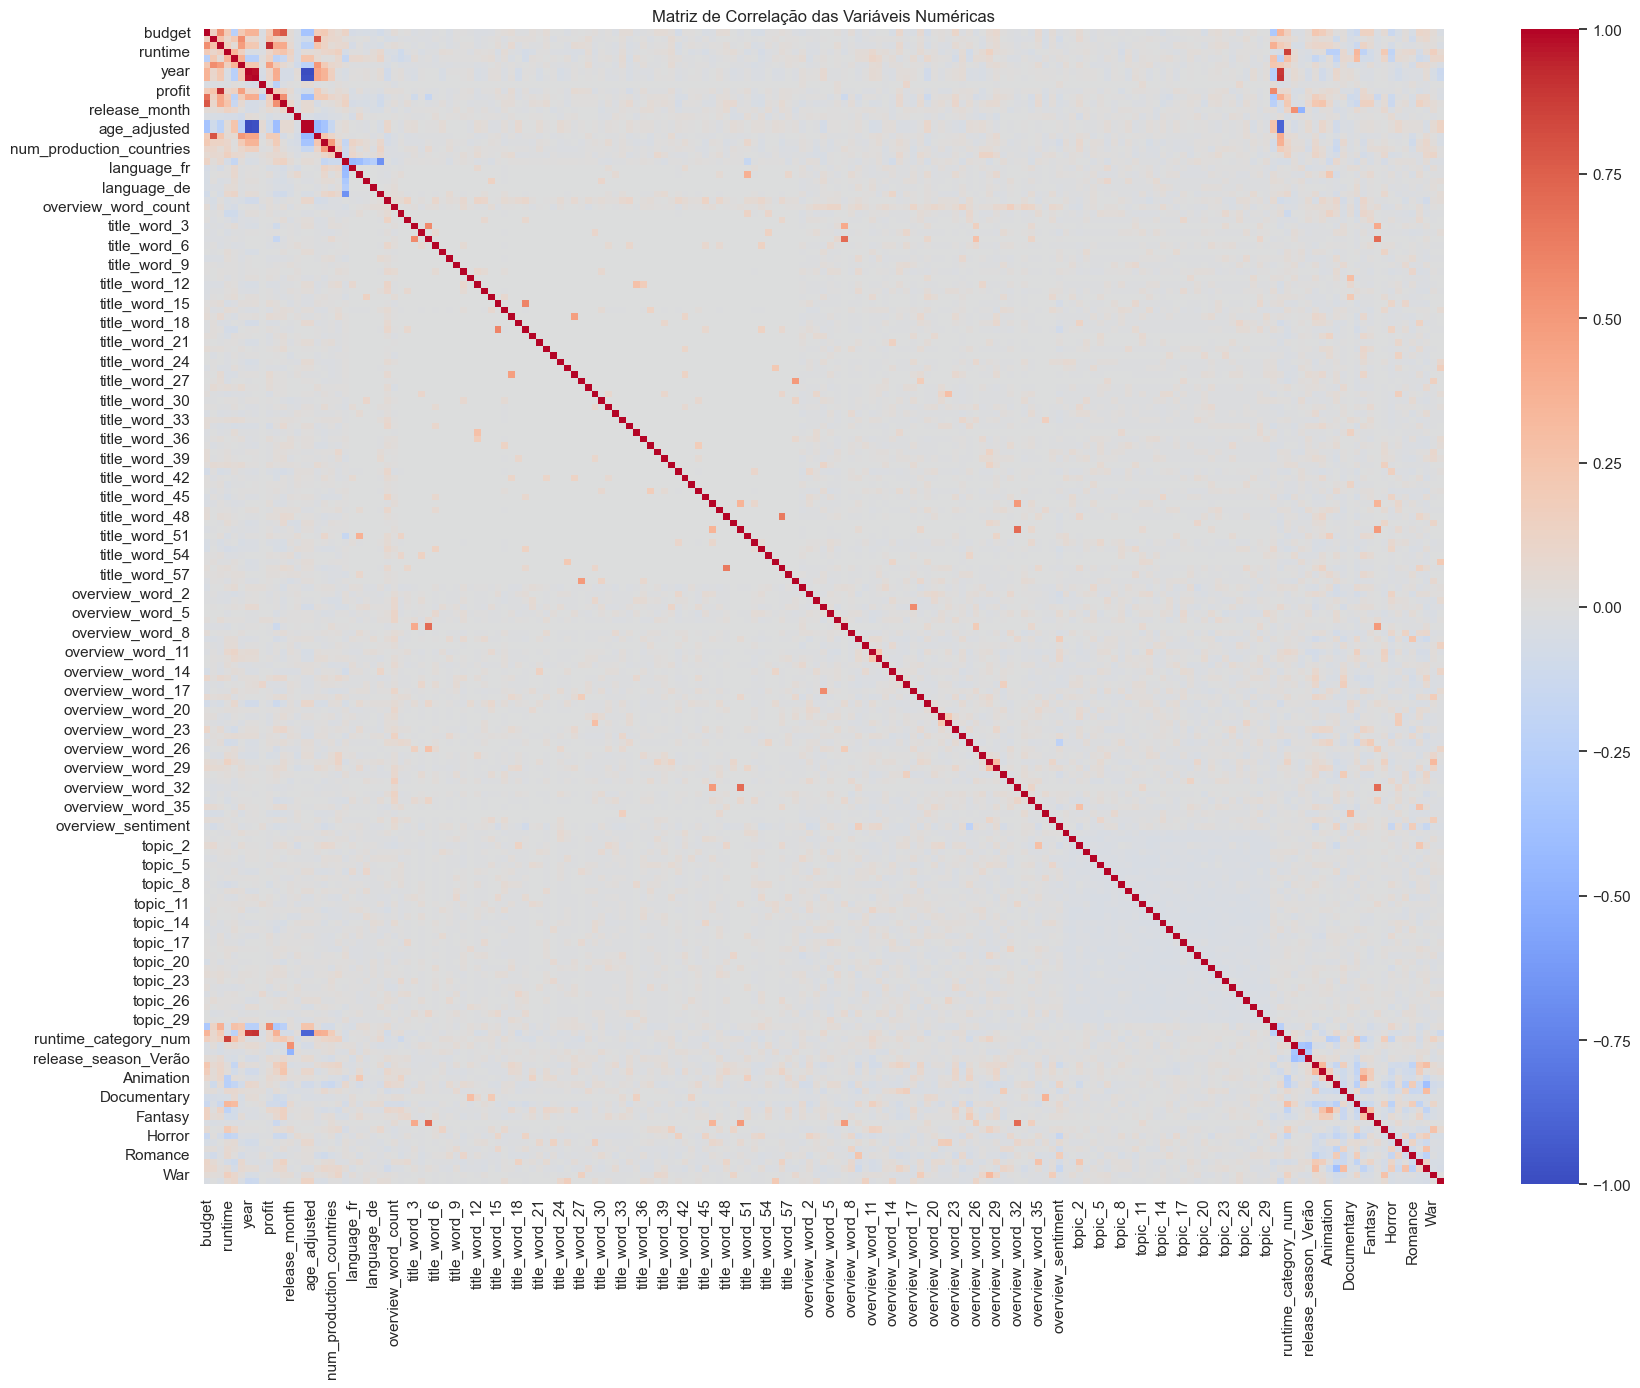

In [264]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculando a matriz de correlação
plt.figure(figsize=(20, 15))
corr_matrix = df.select_dtypes(include=[np.number]).corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Matriz de Correlação das Variáveis Numéricas')
plt.show()


### 3.3.2. Seleção de Variáveis com Base na Variância

Removeremos features com baixa variância, pois elas não contribuem significativamente para a formação de clusters.

In [265]:
from sklearn.feature_selection import VarianceThreshold

# Removendo features com baixa variância
selector = VarianceThreshold(threshold=0.01)  # Ajustar o limiar conforme necessário
selector.fit(df)

# Selecionando as features com alta variância
high_variance_features = df.columns[selector.get_support()]
print(f"Features selecionadas com base na variância: {high_variance_features.tolist()}")

# Atualizando o DataFrame com as features selecionadas
df_var = df[high_variance_features + ''].copy()

Features selecionadas com base na variância: ['budget', 'popularity', 'revenue', 'runtime', 'vote_average', 'vote_count', 'year', 'decade', 'ROI', 'profit', 'budget_log', 'budget_adjusted', 'release_month', 'release_day_of_week', 'age', 'age_adjusted', 'popularity_per_year', 'num_production_companies', 'num_production_countries', 'num_spoken_languages', 'language_en', 'language_other', 'title_word_count', 'overview_word_count', 'title_word_16', 'overview_word_1', 'overview_word_2', 'overview_word_3', 'overview_word_4', 'overview_word_5', 'overview_word_6', 'overview_word_8', 'overview_word_9', 'overview_word_10', 'overview_word_11', 'overview_word_12', 'overview_word_13', 'overview_word_14', 'overview_word_15', 'overview_word_16', 'overview_word_17', 'overview_word_18', 'overview_word_19', 'overview_word_20', 'overview_word_21', 'overview_word_22', 'overview_word_23', 'overview_word_24', 'overview_word_25', 'overview_word_27', 'overview_word_28', 'overview_word_29', 'overview_word_30',

In [266]:
len(df.columns), len(df_var.columns)

(179, 112)

### 3.3.3. Remoção de Features Altamente Correlacionadas

Para evitar redundâncias, removeremos uma das variáveis altamente correlacionadas.

In [267]:
# Identificando pares de features com correlação maior que 0.8
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

high_corr_pairs = [
    (column, row) for column in upper_tri.columns for row in upper_tri.index 
    if abs(upper_tri.loc[row, column]) > 0.8
]

print(f"Paired highly correlated features: {high_corr_pairs}")

# Removendo uma das features de cada par altamente correlacionado
features_to_remove = set()
for pair in high_corr_pairs:
    features_to_remove.add(pair[1])

print(f"Features a serem removidas para evitar multicolinearidade: {list(features_to_remove)}")

# Removendo as features identificadas apenas se elas existirem no DataFrame
existing_features_to_remove = [feature for feature in features_to_remove if feature in df_var.columns]
df_var.drop(columns=existing_features_to_remove, inplace=True)

print(f"Número de features após remoção: {df_var.shape[1]}")


Paired highly correlated features: [('decade', 'year'), ('profit', 'revenue'), ('age', 'year'), ('age', 'decade'), ('age_adjusted', 'year'), ('age_adjusted', 'decade'), ('age_adjusted', 'age'), ('decade_class_num', 'year'), ('decade_class_num', 'decade'), ('decade_class_num', 'age'), ('decade_class_num', 'age_adjusted'), ('runtime_category_num', 'runtime')]
Features a serem removidas para evitar multicolinearidade: ['decade', 'revenue', 'age', 'year', 'runtime', 'age_adjusted']
Número de features após remoção: 106


### 3.3.4. Seleção Final de Variáveis

Com base nas análises anteriores, selecionaremos as variáveis mais relevantes para a análise de clusterização.



In [268]:
# Lista final de features selecionadas
selected_features = df_var.columns.tolist()
print(f"Features finais selecionadas para clusterização: {selected_features}")

# Criando o dataset final para clusterização
cluster_data = df_var.copy()

# Exibindo as primeiras linhas do dataset final
cluster_data.head()

Features finais selecionadas para clusterização: ['budget', 'popularity', 'vote_average', 'vote_count', 'ROI', 'profit', 'budget_log', 'budget_adjusted', 'release_month', 'release_day_of_week', 'popularity_per_year', 'num_production_companies', 'num_production_countries', 'num_spoken_languages', 'language_en', 'language_other', 'title_word_count', 'overview_word_count', 'title_word_16', 'overview_word_1', 'overview_word_2', 'overview_word_3', 'overview_word_4', 'overview_word_5', 'overview_word_6', 'overview_word_8', 'overview_word_9', 'overview_word_10', 'overview_word_11', 'overview_word_12', 'overview_word_13', 'overview_word_14', 'overview_word_15', 'overview_word_16', 'overview_word_17', 'overview_word_18', 'overview_word_19', 'overview_word_20', 'overview_word_21', 'overview_word_22', 'overview_word_23', 'overview_word_24', 'overview_word_25', 'overview_word_27', 'overview_word_28', 'overview_word_29', 'overview_word_30', 'overview_word_31', 'overview_word_33', 'overview_word_34'

,budget,popularity,vote_average,vote_count,ROI,profit,budget_log,budget_adjusted,release_month,release_day_of_week,popularity_per_year,num_production_companies,num_production_countries,num_spoken_languages,language_en,language_other,title_word_count,overview_word_count,title_word_16,overview_word_1,overview_word_2,overview_word_3,overview_word_4,overview_word_5,overview_word_6,overview_word_8,overview_word_9,overview_word_10,overview_word_11,overview_word_12,overview_word_13,overview_word_14,overview_word_15,overview_word_16,overview_word_17,overview_word_18,overview_word_19,overview_word_20,overview_word_21,overview_word_22,overview_word_23,overview_word_24,overview_word_25,overview_word_27,overview_word_28,overview_word_29,overview_word_30,overview_word_31,overview_word_33,overview_word_34,overview_word_35,overview_word_37,overview_sentiment,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,topic_25,topic_26,topic_27,topic_28,topic_29,ROI_category_num,decade_class_num,runtime_category_num,release_season_Outono,release_season_Primavera,release_season_Verão,Action,Adventure,Animation,Comedy,Crime,Drama,Family,Fantasy,History,Horror,Music,Mystery,Romance,Science Fiction,Thriller,War,Western
1,65000000.0,17.015539,6.9,2413.0,3.043035,197797249.0,17.989898,2.201131e+08,12,4,0.586743,3,1,2,1,0,1,67,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,-0.218750,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,2,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0
3,16000000.0,3.859495,6.1,34.0,4.090760,65452156.0,16.588099,5.418168e+07,12,4,0.133086,1,1,1,1,0,3,45,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.600000,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,3,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0
8,35000000.0,5.231580,5.5,174.0,0.838576,29350171.0,17.370859,1.185224e+08,12,4,0.180399,3,1,1,1,0,2,70,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.116667,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
10,62000000.0,6.318445,6.5,199.0,0.739992,45879496.0,17.942645,2.099540e+08,11,4,0.217877,2,1,1,1,0,3,44,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.320000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0
14,98000000.0,7.284477,5.7,137.0,-0.897782,-87982678.0,18.400478,3.318628e+08,12,4,0.251189,4,4,2,1,0,2,68,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.128571,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,2,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [269]:
cluster_data

,budget,popularity,vote_average,vote_count,ROI,profit,budget_log,budget_adjusted,release_month,release_day_of_week,popularity_per_year,num_production_companies,num_production_countries,num_spoken_languages,language_en,language_other,title_word_count,overview_word_count,title_word_16,overview_word_1,overview_word_2,overview_word_3,overview_word_4,overview_word_5,overview_word_6,overview_word_8,overview_word_9,overview_word_10,overview_word_11,overview_word_12,overview_word_13,overview_word_14,overview_word_15,overview_word_16,overview_word_17,overview_word_18,overview_word_19,overview_word_20,overview_word_21,overview_word_22,overview_word_23,overview_word_24,overview_word_25,overview_word_27,overview_word_28,overview_word_29,overview_word_30,overview_word_31,overview_word_33,overview_word_34,overview_word_35,overview_word_37,overview_sentiment,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,topic_25,topic_26,topic_27,topic_28,topic_29,ROI_category_num,decade_class_num,runtime_category_num,release_season_Outono,release_season_Primavera,release_season_Verão,Action,Adventure,Animation,Comedy,Crime,Drama,Family,Fantasy,History,Horror,Music,Mystery,Romance,Science Fiction,Thriller,War,Western
1,65000000.0,17.015539,6.9,2413.0,3.043035,197797249.0,17.989898,2.201131e+08,12,4,0.586743,3,1,2,1,0,1,67,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,-0.218750,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,2,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0
3,16000000.0,3.859495,6.1,34.0,4.090760,65452156.0,16.588099,5.418168e+07,12,4,0.133086,1,1,1,1,0,3,45,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.600000,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,3,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0
8,35000000.0,5.231580,5.5,174.0,0.838576,29350171.0,17.370859,1.185224e+08,12,4,0.180399,3,1,1,1,0,2,70,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.116667,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
10,62000000.0,6.318445,6.5,199.0,0.739992,45879496.0,17.942645,2.099540e+08,11,4,0.217877,2,1,1,1,0,3,44,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.320000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0
14,98000000.0,7.284477,5.7,137.0,-0.897782,-87982678.0,18.400478,3.318628e+08,12,4,0.251189,4,4,2,1,0,2,68,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.128571,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,2,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9064,10000000.0,13.178900,6.1,1356.0,10.858788,108587880.0,16.118096,1.215506e+07,6,2,1.647363,4,2,1,1,0,4,75,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,-0.065000,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
9065,33000000.0,12.237571,5.9,901.0,1.335401,44068246.0,17.312018,4.011171e+07,7,3,1.529696,3,1,1,1,0,6,80,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.321429,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
9069,19000000.0,14.983700,7.1,2262.0,3.486395,66241496.0,16.759950,2.309462e+07,7,2,1.872963,3,1,1,1,0,1,85,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,

## 3.4. Redução de Dimensionalidade

Com um número significativo de features, a redução de dimensionalidade pode ajudar a melhorar a eficiência e a performance dos algoritmos de clusterização. Aplicaremos a **Análise de Componentes Principais (PCA)** para reduzir a dimensionalidade do dataset, mantendo a maior parte da variância dos dados.

### 3.4.1. Aplicação da PCA

A PCA transforma as variáveis originais em um novo conjunto de variáveis não correlacionadas chamadas de componentes principais. Escolheremos o número de componentes que explicam pelo menos 95% da variância dos dados.

Dimensionalidade original: 106
Dimensionalidade após PCA: 90


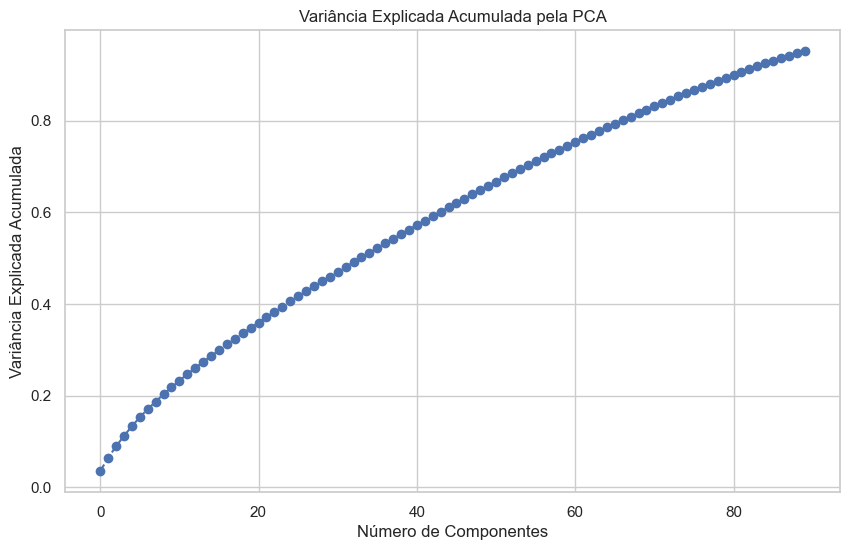

In [270]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Escalando os dados antes da PCA
scaler = StandardScaler()
cluster_data_scaled = scaler.fit_transform(cluster_data)

# Aplicando PCA
pca = PCA(n_components=0.95, random_state=42)  # Mantendo 95% da variância
pca.fit(cluster_data_scaled)

# Transformando os dados
cluster_data_pca = pca.transform(cluster_data_scaled)

print(f"Dimensionalidade original: {cluster_data_scaled.shape[1]}")
print(f"Dimensionalidade após PCA: {cluster_data_pca.shape[1]}")

# Visualizando a variância explicada acumulada
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.title('Variância Explicada Acumulada pela PCA')
plt.xlabel('Número de Componentes')
plt.ylabel('Variância Explicada Acumulada')
plt.grid(True)
plt.show()

### 3.4.2. Consideração de Outras Técnicas de Redução de Dimensionalidade

Além da PCA, podemos considerar outras técnicas como **t-Distributed Stochastic Neighbor Embedding (t-SNE)** ou **Uniform Manifold Approximation and Projection (UMAP)** para visualização ou pré-processamento, especialmente se quisermos capturar relações não lineares entre as features.

In [271]:
# Selecionando algumas variáveis para visualização
# Definindo o gênero principal como o primeiro gênero presente

# Função para determinar o gênero principal
def get_primary_genre(row):
    for genre in top_genres:
        if row[genre] == 1:
            return genre
    return 'Other'

# Aplicando a função
df['primary_genre'] = df.apply(get_primary_genre, axis=1)

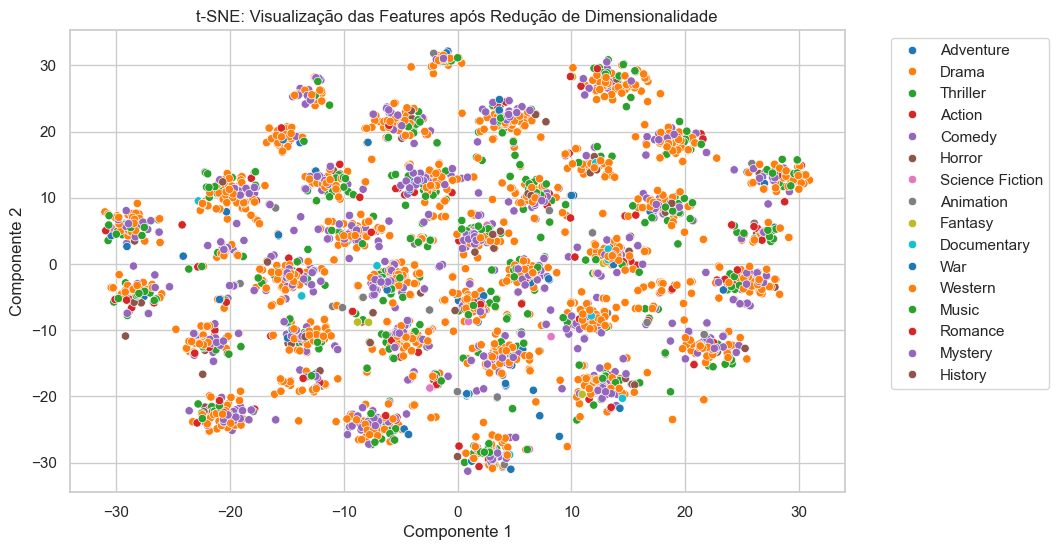

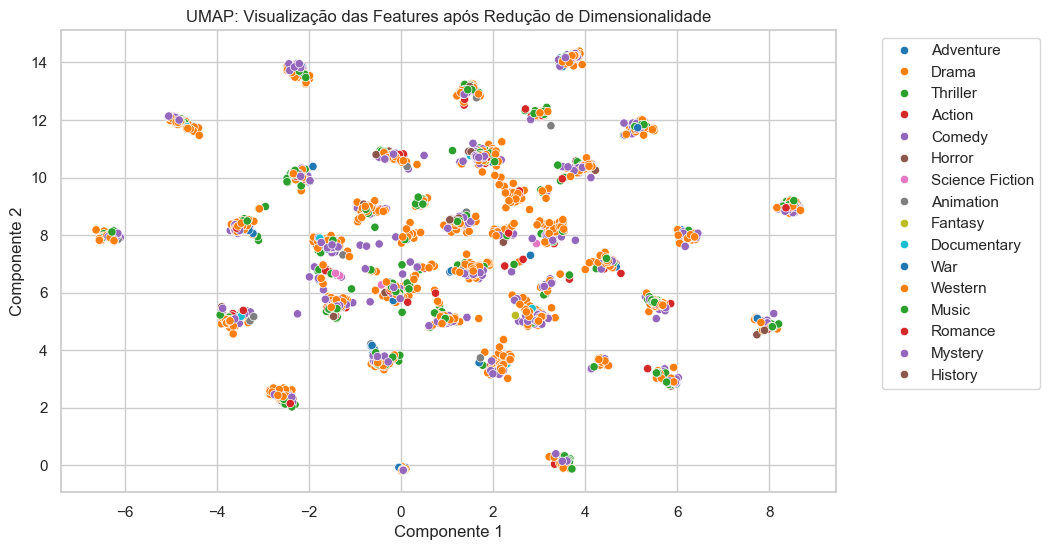

In [272]:
from sklearn.manifold import TSNE
import umap

# Aplicando t-SNE para redução para 2 dimensões (apenas para visualização)
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=300)
cluster_data_tsne = tsne.fit_transform(cluster_data_scaled)

# Plotando os resultados do t-SNE
plt.figure(figsize=(10, 6))
sns.scatterplot(x=cluster_data_tsne[:,0], y=cluster_data_tsne[:,1], hue='primary_genre', palette='tab10', data=df)
plt.title('t-SNE: Visualização das Features após Redução de Dimensionalidade')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


umap_reducer = umap.UMAP(n_components=2, random_state=42)
cluster_data_umap = umap_reducer.fit_transform(cluster_data_scaled)

# Plotando os resultados do UMAP
plt.figure(figsize=(10, 6))
sns.scatterplot(x=cluster_data_umap[:,0], y=cluster_data_umap[:,1], hue='primary_genre', palette='tab10', data=df)
plt.title('UMAP: Visualização das Features após Redução de Dimensionalidade')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### 3.4.3. Conclusão da Redução de Dimensionalidade

Aplicamos a PCA para reduzir a dimensionalidade do dataset mantendo 95% da variância original. Também exploramos técnicas alternativas como t-SNE e UMAP para visualizações, que podem ser úteis para interpretar os clusters formados nos passos seguintes.

## 3.5. Revisão Final das Features Preparadas

Após a transformação, seleção e redução de dimensionalidade, revisaremos o conjunto de dados preparado para garantir que está pronto para ser utilizado nos algoritmos de clusterização.

In [273]:
# Confirmando as dimensões do dataset após a redução de dimensionalidade
print(f"Dimensionalidade final para clusterização (PCA): {cluster_data_pca.shape}")

# Opcional: Converter o array PCA para um DataFrame para facilitar a manipulação futura
cluster_data_pca_df = pd.DataFrame(cluster_data_pca, 
                                   columns=[f'PC{i+1}' for i in range(cluster_data_pca.shape[1])])

# Exibindo as primeiras linhas do dataset reduzido
cluster_data_pca_df.head()

Dimensionalidade final para clusterização (PCA): (2987, 90)


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50,PC51,PC52,PC53,PC54,PC55,PC56,PC57,PC58,PC59,PC60,PC61,PC62,PC63,PC64,PC65,PC66,PC67,PC68,PC69,PC70,PC71,PC72,PC73,PC74,PC75,PC76,PC77,PC78,PC79,PC80,PC81,PC82,PC83,PC84,PC85,PC86,PC87,PC88,PC89,PC90
0,3.966582,-1.796336,3.160692,2.040565,2.611260,-1.768338,-0.065661,1.280929,-1.866852,-1.382529,-1.183668,-0.637707,-1.520770,-0.184094,-0.634085,-0.444478,-0.092950,2.823533,-1.341126,-0.424936,-1.841989,0.418736,0.672722,0.596385,-0.327488,0.183125,0.218380,0.105768,-0.337915,-0.427666,-0.719883,-0.596992,-0.518754,2.368901,-0.009327,1.157603,1.342710,-0.493181,0.481255,1.734185,1.630078,1.284579,-1.170270,0.249429,1.230341,-0.196430,0.459172,-0.689634,-0.121853,-0.275277,0.216834,0.115676,1.967070,-0.639043,-0.043799,0.156152,0.999842,0.302938,-0.051235,-1.406361,1.260358,0.742262,0.473663,-0.346243,-0.563983,-0.016182,0.540384,-0.612004,-0.430114,-0.854941,0.384921,-0.480348,0.097137,0.600477,-0.290596,-0.673212,0.774222,-0.203141,0.509040,0.207649,0.048650,-0.697305,0.915600,-0.992231,0.158403,0.099446,-1.202975,-0.065562,-0.961175,-0.313591
1,-2.307496,-0.131852,1.629820,-1.718388,-0.514360,-1.391922,-0.725025,-0.260177,-0.068722,0.197683,-0.739967,-1.150934,0.324082,0.178932,1.042683,0.429555,-0.516214,0.287878,0.909142,0.415009,-1.500089,-0.133837,0.027636,-0.078084,-0.917969,-0.324941,-0.656718,-0.408984,-0.217497,0.219734,-0.940202,1.186055,-0.286581,-1.158102,0.851279,-0.599402,0.874935,0.746587,0.850689,-0.329813,-0.140656,0.379352,-0.314878,-0.609059,-0.721461,0.231328,0.819769,-0.199485,0.563996,-0.860838,-0.835216,0.012530,-0.513160,0.359329,-0.942926,0.774441,-0.046373,-0.073380,-0.163047,-0.197128,0.188884,0.130544,-1.114084,-0.061108,-0.130265,-0.016022,-0.477566,0.909824,-0.342815,0.460750,-0.483630,0.264304,0.826074,0.736906,1.232372,-0.762815,0.410839,0.309984,0.127979,-0.297552,-0.531092,0.083790,1.490812,0.387403,0.782169,0.017932,-1.106325,0.100787,0.511400,0.489107
2,1.231408,-1.678744,-1.582204,-0.904737,0.731282,-1.124745,0.180355,0.876422,-0.310706,-0.227731,0.305732,-0.621257,-0.140991,0.598984,0.533886,0.101374,0.299833,0.969644,0.576903,0.251202,0.122458,0.944978,0.610854,-1.859708,-0.902524,-0.726852,-0.522130,-0.938018,-0.340207,0.353250,-0.139766,-0.850372,0.527821,-0.347458,0.101658,-0.220752,0.237484,0.071887,0.591839,-0.203507,-1.714645,-0.704061,-1.853258,0.081665,2.194276,1.964842,-1.148825,-0.618445,-0.629708,0.684666,0.976446,-0.532028,0.097564,1.082934,-0.597607,-0.248769,-0.416864,0.277053,0.592085,-0.155400,-0.097500,-0.294621,-0.212387,0.667918,-0.222406,0.302460,0.173497,0.204369,0.991471,0.266230,0.553327,-0.470294,-0.694323,-0.128641,0.154263,0.996241,-0.156203,0.816528,-0.455049,-0.330328,-0.144730,0.761943,-0.232550,0.542677,-0.666193,0.430395,-0.592122,-0.030810,-0.088316,-1.204231
3,-0.311948,-0.899106,1.543618,-2.389703,-1.201032,-2.199604,0.362812,0.087980,-0.568832,0.052584,-0.674542,-1.403763,-0.096157,0.875983,-0.308360,-1.466737,-0.336203,1.164207,0.863206,-0.331816,-0.504192,-0.410278,-0.418580,1.233262,-0.104402,-0.578498,-0.734950,0.618458,1.730207,1.526460,0.473407,1.251907,0.123666,-1.216648,0.131700,-0.872870,0.041625,-1.362921,-0.862184,0.491427,0.307896,0.141543,-0.900957,0.648297,-0.473287,-0.806295,-1.111069,-0.377142,0.121606,0.290859,1.095748,0.669316,-0.109230,0.062761,1.550429,0.628526,-0.514344,-0.390662,-0.095577,0.016908,0.802914,0.032414,-0.792711,0.080508,0.740013,0.913188,-1.072886,0.432492,1.198289,0.424720,-0.831813,0.392270,0.155263,-0.526687,0.154690,-0.460037,0.627934,0.105110,0.385903,-0.212187,0.080680,0.320183,0.059467,0.517799,0.938287,0.675720,-0.375789,0.366573,0.275685,0.210008
4,3.752000,-2.156793,-0.934368,-3.043309,0.302694,-0.057826,0.581808,0.642386,-0.470584,0.697617,-0.725578,-0.420335,0.285442,1.

## 3.6. Análise Exploratório Visual das Features Preparadas

Antes de avançar para a clusterização, realizaremos uma análise exploratória visual para entender como os atributos criados se distribuem entre os filmes de diferentes gêneros.

### 3.6.1. Distribuição das Features Selecionadas por Gênero

Utilizaremos gráficos de boxplot e countplots para visualizar a distribuição das features categóricas e numéricas em relação aos gêneros principais.



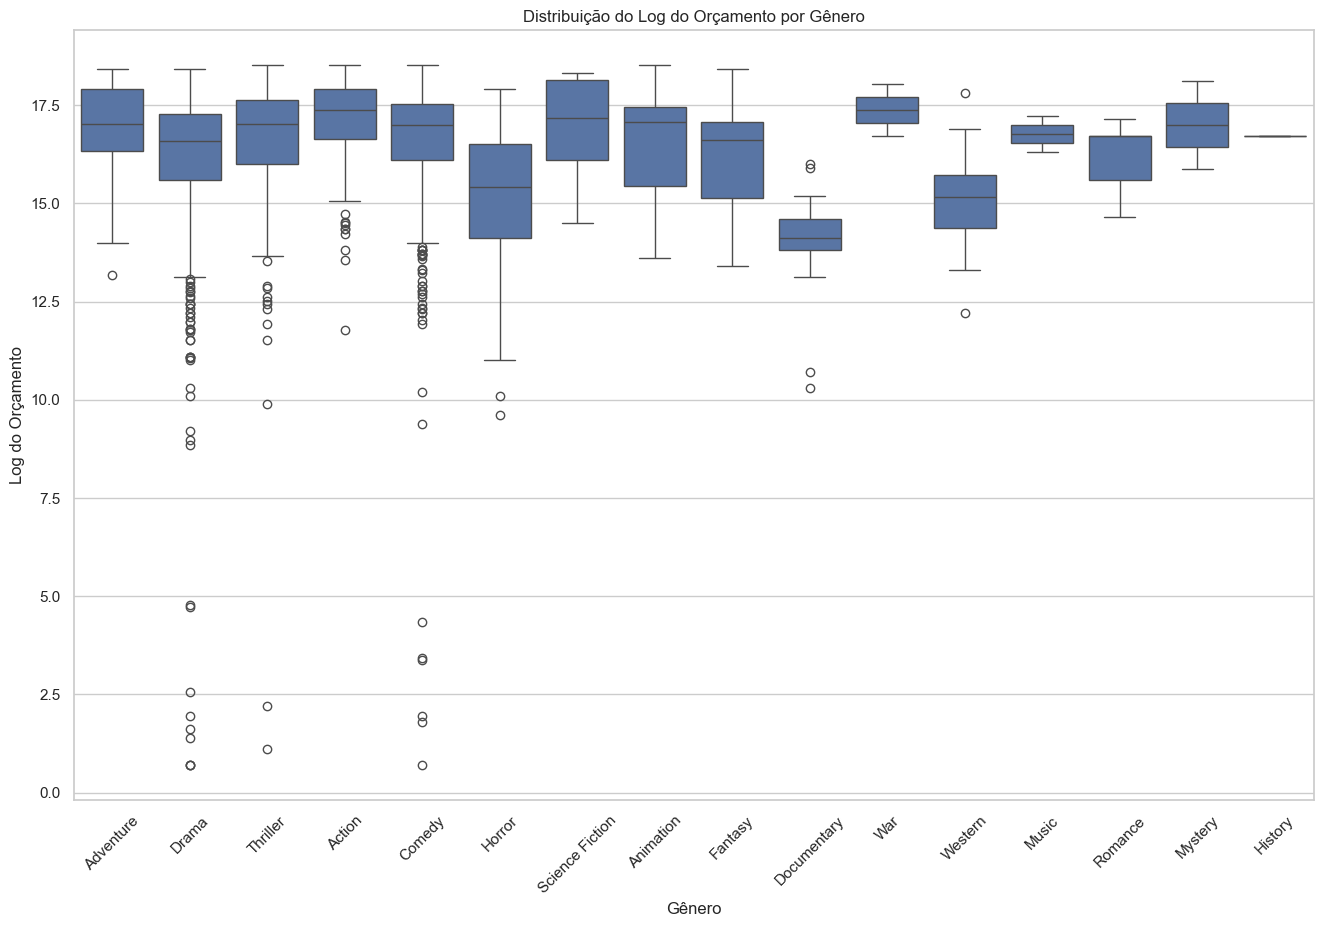

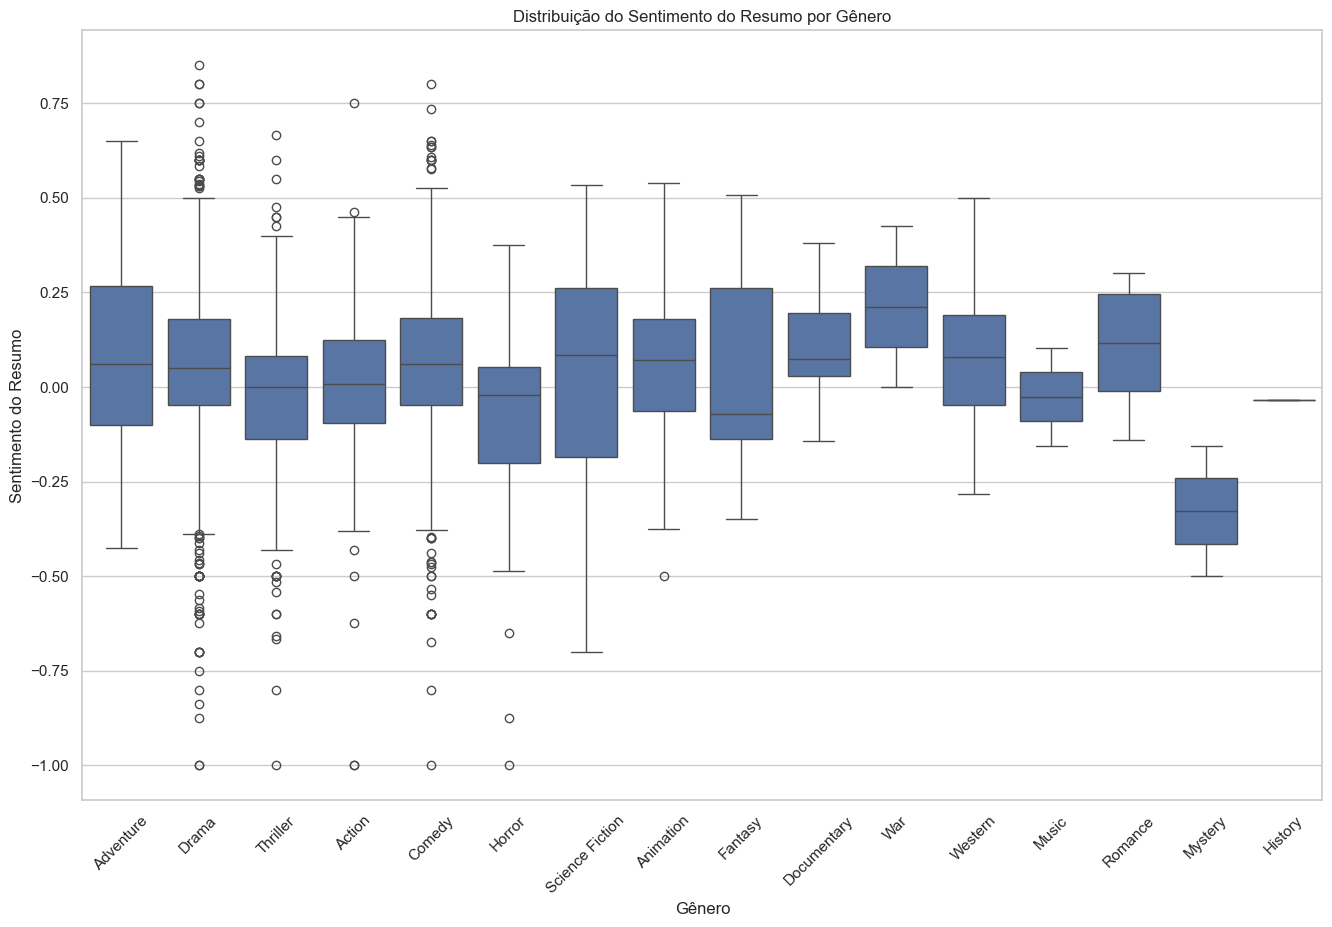

In [274]:
# Plotando a distribuição do log do orçamento por gênero
plt.figure(figsize=(16, 10))
sns.boxplot(x='primary_genre', y='budget_log', data=df)
plt.title('Distribuição do Log do Orçamento por Gênero')
plt.xlabel('Gênero')
plt.ylabel('Log do Orçamento')
plt.xticks(rotation=45)
plt.show()

# Plotando a distribuição do sentimento do resumo por gênero
plt.figure(figsize=(16, 10))
sns.boxplot(x='primary_genre', y='overview_sentiment', data=df)
plt.title('Distribuição do Sentimento do Resumo por Gênero')
plt.xlabel('Gênero')
plt.ylabel('Sentimento do Resumo')
plt.xticks(rotation=45)
plt.show()

In [275]:
df.head(5)

,budget,popularity,revenue,runtime,vote_average,vote_count,year,decade,ROI,profit,budget_log,budget_adjusted,release_month,release_day_of_week,age,age_adjusted,popularity_per_year,num_production_companies,num_production_countries,num_spoken_languages,language_en,language_fr,language_ja,language_es,language_de,language_other,title_word_count,overview_word_count,title_word_1,title_word_2,title_word_3,title_word_4,title_word_5,title_word_6,title_word_7,title_word_8,title_word_9,title_word_10,title_word_11,title_word_12,title_word_13,title_word_14,title_word_15,title_word_16,title_word_17,title_word_18,title_word_19,title_word_20,title_word_21,title_word_22,title_word_23,title_word_24,title_word_25,title_word_26,title_word_27,title_word_28,title_word_29,title_word_30,title_word_31,title_word_32,title_word_33,title_word_34,title_word_35,title_word_36,title_word_37,title_word_38,title_word_39,title_word_40,title_word_41,title_word_42,title_word_43,title_word_44,title_word_45,title_word_46,title_word_47,title_word_48,title_word_49,title_word_50,title_word_51,title_word_52,title_word_53,title_word_54,title_word_55,title_word_56,title_word_57,title_word_58,overview_word_1,overview_word_2,overview_word_3,overview_word_4,overview_word_5,overview_word_6,overview_word_7,overview_word_8,overview_word_9,overview_word_10,overview_word_11,overview_word_12,overview_word_13,overview_word_14,overview_word_15,overview_word_16,overview_word_17,overview_word_18,overview_word_19,overview_word_20,overview_word_21,overview_word_22,overview_word_23,overview_word_24,overview_word_25,overview_word_26,overview_word_27,overview_word_28,overview_word_29,overview_word_30,overview_word_31,overview_word_32,overview_word_33,overview_word_34,overview_word_35,overview_word_36,overview_word_37,overview_sentiment,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,topic_25,topic_26,topic_27,topic_28,topic_29,ROI_category_num,decade_class_num,runtime_category_num,release_season_Outono,release_season_Primavera,release_season_Verão,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,Thriller,War,Western,primary_genre
1,65000000.0,17.015539,262797249.0,104.0,6.9,2413.0,1995.0,1990.0,3.043035,197797249.0,17.989898,2.201131e+08,12,4,29.0,29.0,0.586743,3,1,2,1,0,0,0,0,0,1,67,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,-0.218750,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,2,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,Adventure
3,16000000.0,3.859495,81452156.0,127.0,6.1,34.0,1995.0,1990.0,4.090760,65452156.0,16.588099,5.418168e+07,12,4,29.0,29.0,0.133086,1,1,1,1,0,0,0,0,0,3,45,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.600000,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,3,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,Drama
8,35000000.0,5.231580,64350171.0,106.0,5.5,174.0,1995.0,1990.0,0.838576,29350171.0,17.370859,1.185224e+08,12,4,29.0,29.0,0.180399,3,1,1,1,0,0,0,0,0,2,70,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.116667,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,Thriller
10,62000000.0,6.318445,107879496.0,106.0,6.5,199.0,1995.0,1990.0,0.739992,45879496.0,17.942645,2.099540e+08,11,4,29.0,29.0,0.217877,2,1,1,1,0,0,0,0,0,3,44,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,

In [276]:
cluster_data_pca_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50,PC51,PC52,PC53,PC54,PC55,PC56,PC57,PC58,PC59,PC60,PC61,PC62,PC63,PC64,PC65,PC66,PC67,PC68,PC69,PC70,PC71,PC72,PC73,PC74,PC75,PC76,PC77,PC78,PC79,PC80,PC81,PC82,PC83,PC84,PC85,PC86,PC87,PC88,PC89,PC90
0,3.966582,-1.796336,3.160692,2.040565,2.611260,-1.768338,-0.065661,1.280929,-1.866852,-1.382529,-1.183668,-0.637707,-1.520770,-0.184094,-0.634085,-0.444478,-0.092950,2.823533,-1.341126,-0.424936,-1.841989,0.418736,0.672722,0.596385,-0.327488,0.183125,0.218380,0.105768,-0.337915,-0.427666,-0.719883,-0.596992,-0.518754,2.368901,-0.009327,1.157603,1.342710,-0.493181,0.481255,1.734185,1.630078,1.284579,-1.170270,0.249429,1.230341,-0.196430,0.459172,-0.689634,-0.121853,-0.275277,0.216834,0.115676,1.967070,-0.639043,-0.043799,0.156152,0.999842,0.302938,-0.051235,-1.406361,1.260358,0.742262,0.473663,-0.346243,-0.563983,-0.016182,0.540384,-0.612004,-0.430114,-0.854941,0.384921,-0.480348,0.097137,0.600477,-0.290596,-0.673212,0.774222,-0.203141,0.509040,0.207649,0.048650,-0.697305,0.915600,-0.992231,0.158403,0.099446,-1.202975,-0.065562,-0.961175,-0.313591
1,-2.307496,-0.131852,1.629820,-1.718388,-0.514360,-1.391922,-0.725025,-0.260177,-0.068722,0.197683,-0.739967,-1.150934,0.324082,0.178932,1.042683,0.429555,-0.516214,0.287878,0.909142,0.415009,-1.500089,-0.133837,0.027636,-0.078084,-0.917969,-0.324941,-0.656718,-0.408984,-0.217497,0.219734,-0.940202,1.186055,-0.286581,-1.158102,0.851279,-0.599402,0.874935,0.746587,0.850689,-0.329813,-0.140656,0.379352,-0.314878,-0.609059,-0.721461,0.231328,0.819769,-0.199485,0.563996,-0.860838,-0.835216,0.012530,-0.513160,0.359329,-0.942926,0.774441,-0.046373,-0.073380,-0.163047,-0.197128,0.188884,0.130544,-1.114084,-0.061108,-0.130265,-0.016022,-0.477566,0.909824,-0.342815,0.460750,-0.483630,0.264304,0.826074,0.736906,1.232372,-0.762815,0.410839,0.309984,0.127979,-0.297552,-0.531092,0.083790,1.490812,0.387403,0.782169,0.017932,-1.106325,0.100787,0.511400,0.489107
2,1.231408,-1.678744,-1.582204,-0.904737,0.731282,-1.124745,0.180355,0.876422,-0.310706,-0.227731,0.305732,-0.621257,-0.140991,0.598984,0.533886,0.101374,0.299833,0.969644,0.576903,0.251202,0.122458,0.944978,0.610854,-1.859708,-0.902524,-0.726852,-0.522130,-0.938018,-0.340207,0.353250,-0.139766,-0.850372,0.527821,-0.347458,0.101658,-0.220752,0.237484,0.071887,0.591839,-0.203507,-1.714645,-0.704061,-1.853258,0.081665,2.194276,1.964842,-1.148825,-0.618445,-0.629708,0.684666,0.976446,-0.532028,0.097564,1.082934,-0.597607,-0.248769,-0.416864,0.277053,0.592085,-0.155400,-0.097500,-0.294621,-0.212387,0.667918,-0.222406,0.302460,0.173497,0.204369,0.991471,0.266230,0.553327,-0.470294,-0.694323,-0.128641,0.154263,0.996241,-0.156203,0.816528,-0.455049,-0.330328,-0.144730,0.761943,-0.232550,0.542677,-0.666193,0.430395,-0.592122,-0.030810,-0.088316,-1.204231
3,-0.311948,-0.899106,1.543618,-2.389703,-1.201032,-2.199604,0.362812,0.087980,-0.568832,0.052584,-0.674542,-1.403763,-0.096157,0.875983,-0.308360,-1.466737,-0.336203,1.164207,0.863206,-0.331816,-0.504192,-0.410278,-0.418580,1.233262,-0.104402,-0.578498,-0.734950,0.618458,1.730207,1.526460,0.473407,1.251907,0.123666,-1.216648,0.131700,-0.872870,0.041625,-1.362921,-0.862184,0.491427,0.307896,0.141543,-0.900957,0.648297,-0.473287,-0.806295,-1.111069,-0.377142,0.121606,0.290859,1.095748,0.669316,-0.109230,0.062761,1.550429,0.628526,-0.514344,-0.390662,-0.095577,0.016908,0.802914,0.032414,-0.792711,0.080508,0.740013,0.913188,-1.072886,0.432492,1.198289,0.424720,-0.831813,0.392270,0.155263,-0.526687,0.154690,-0.460037,0.627934,0.105110,0.385903,-0.212187,0.080680,0.320183,0.059467,0.517799,0.938287,0.675720,-0.375789,0.366573,0.275685,0.210008
4,3.752000,-2.156793,-0.934368,-3.043309,0.302694,-0.057826,0.581808,0.642386,-0.470584,0.697617,-0.725578,-0.420335,0.285442,1.

In [277]:
df

,budget,popularity,revenue,runtime,vote_average,vote_count,year,decade,ROI,profit,budget_log,budget_adjusted,release_month,release_day_of_week,age,age_adjusted,popularity_per_year,num_production_companies,num_production_countries,num_spoken_languages,language_en,language_fr,language_ja,language_es,language_de,language_other,title_word_count,overview_word_count,title_word_1,title_word_2,title_word_3,title_word_4,title_word_5,title_word_6,title_word_7,title_word_8,title_word_9,title_word_10,title_word_11,title_word_12,title_word_13,title_word_14,title_word_15,title_word_16,title_word_17,title_word_18,title_word_19,title_word_20,title_word_21,title_word_22,title_word_23,title_word_24,title_word_25,title_word_26,title_word_27,title_word_28,title_word_29,title_word_30,title_word_31,title_word_32,title_word_33,title_word_34,title_word_35,title_word_36,title_word_37,title_word_38,title_word_39,title_word_40,title_word_41,title_word_42,title_word_43,title_word_44,title_word_45,title_word_46,title_word_47,title_word_48,title_word_49,title_word_50,title_word_51,title_word_52,title_word_53,title_word_54,title_word_55,title_word_56,title_word_57,title_word_58,overview_word_1,overview_word_2,overview_word_3,overview_word_4,overview_word_5,overview_word_6,overview_word_7,overview_word_8,overview_word_9,overview_word_10,overview_word_11,overview_word_12,overview_word_13,overview_word_14,overview_word_15,overview_word_16,overview_word_17,overview_word_18,overview_word_19,overview_word_20,overview_word_21,overview_word_22,overview_word_23,overview_word_24,overview_word_25,overview_word_26,overview_word_27,overview_word_28,overview_word_29,overview_word_30,overview_word_31,overview_word_32,overview_word_33,overview_word_34,overview_word_35,overview_word_36,overview_word_37,overview_sentiment,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,topic_25,topic_26,topic_27,topic_28,topic_29,ROI_category_num,decade_class_num,runtime_category_num,release_season_Outono,release_season_Primavera,release_season_Verão,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,Thriller,War,Western,primary_genre
1,65000000.0,17.015539,262797249.0,104.0,6.9,2413.0,1995.0,1990.0,3.043035,197797249.0,17.989898,2.201131e+08,12,4,29.0,29.0,0.586743,3,1,2,1,0,0,0,0,0,1,67,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,-0.218750,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,2,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,Adventure
3,16000000.0,3.859495,81452156.0,127.0,6.1,34.0,1995.0,1990.0,4.090760,65452156.0,16.588099,5.418168e+07,12,4,29.0,29.0,0.133086,1,1,1,1,0,0,0,0,0,3,45,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.600000,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,3,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,Drama
8,35000000.0,5.231580,64350171.0,106.0,5.5,174.0,1995.0,1990.0,0.838576,29350171.0,17.370859,1.185224e+08,12,4,29.0,29.0,0.180399,3,1,1,1,0,0,0,0,0,2,70,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.116667,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,Thriller
10,62000000.0,6.318445,107879496.0,106.0,6.5,199.0,1995.0,1990.0,0.739992,45879496.0,17.942645,2.099540e+08,11,4,29.0,29.0,0.217877,2,1,1,1,0,0,0,0,0,3,44,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,

# 4. Escolha de Modelos e Estratégias

Neste notebook, exploraremos diferentes algoritmos de clustering para analisar nosso conjunto de dados. Avaliaremos modelos clássicos e avançados, escolhendo o número ideal de clusters e ajustando hiperparâmetros para obter os melhores resultados possíveis.

## 4.1. Modelos Clássicos

In [290]:
# Importando bibliotecas necessárias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import DBSCAN, SpectralClustering
from sklearn.neighbors import NearestNeighbors

import warnings
warnings.filterwarnings('ignore')

# Configurando estilo dos gráficos
sns.set(style='whitegrid', palette='muted', color_codes=True)
%matplotlib inline

### 4.1.1. K-Means Clustering

**Descrição:**

O K-Means é um dos algoritmos de clustering mais populares e simples de implementar. Ele particiona os dados em K clusters, onde cada ponto pertence ao cluster com o centroide mais próximo.

#### Analisando os Resultados para Escolha do Número de Clusters

Vamos visualizar as métricas para diferentes números de clusters e diferentes métricas de distância para determinar a melhor combinação.

#### Escolha do Número de Clusters

**Métodos Utilizados:**

- **Método do Cotovelo (Elbow Method)**
- **Silhouette Score**
- **Calinski-Harabasz Index**
- **Davies-Bouldin Index**
- **Critério de Informação de Akaike (AIC)**
- **Critério de Informação Bayesiano (BIC)**

In [307]:
nb_clusters = range(2, 150)
data = cluster_data_pca_df.to_numpy()

### Método do Cotovelo

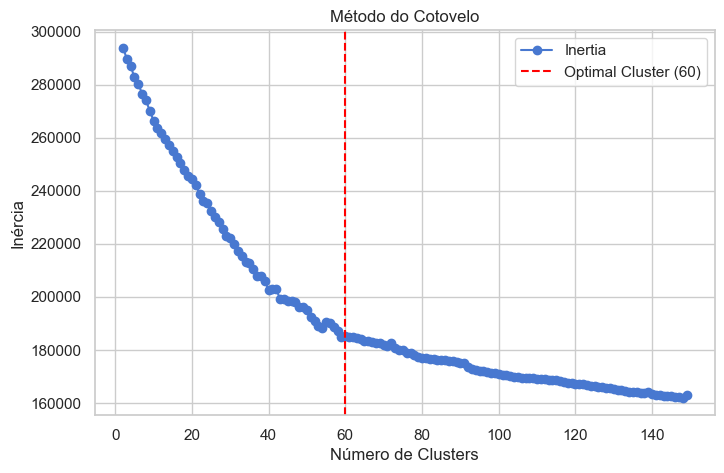

In [309]:
# Calculate inertias
inertias = []
for n in nb_clusters:
    kmeans = KMeans(n_clusters=n, random_state=42)
    kmeans.fit(data)
    inertias.append(kmeans.inertia_)

# Plotting the Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(nb_clusters, inertias, marker='o', label="Inertia")
plt.axvline(x=60, color='red', linestyle='--', label="Optimal Cluster (60)")
plt.title("Método do Cotovelo")
plt.xlabel("Número de Clusters")
plt.ylabel("Inércia")
plt.grid(True)
plt.legend()
plt.show()

### Silhouette Score

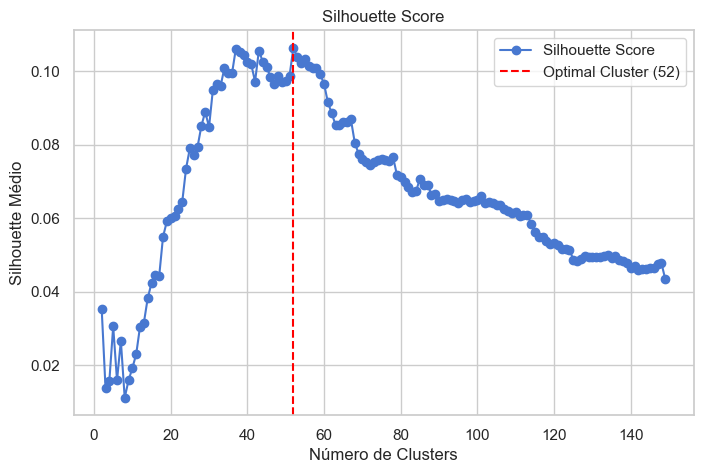

In [310]:
# Calculate silhouette scores
silhouette_scores = []
for n in nb_clusters:
    if n > 1:  # Silhouette score is undefined for a single cluster
        kmeans = KMeans(n_clusters=n, random_state=42)
        labels = kmeans.fit_predict(data)
        silhouette_scores.append(silhouette_score(data, labels))
    else:
        silhouette_scores.append(np.nan)  # Placeholder for single cluster

# Plotting the Silhouette Score
plt.figure(figsize=(8, 5))
plt.plot(nb_clusters, silhouette_scores, marker='o', label="Silhouette Score")
plt.axvline(x=52, color='red', linestyle='--', label="Optimal Cluster (52)")
plt.title("Silhouette Score")
plt.xlabel("Número de Clusters")
plt.ylabel("Silhouette Médio")
plt.grid(True)
plt.legend()
plt.show()


### Calinski-Harabasz Index

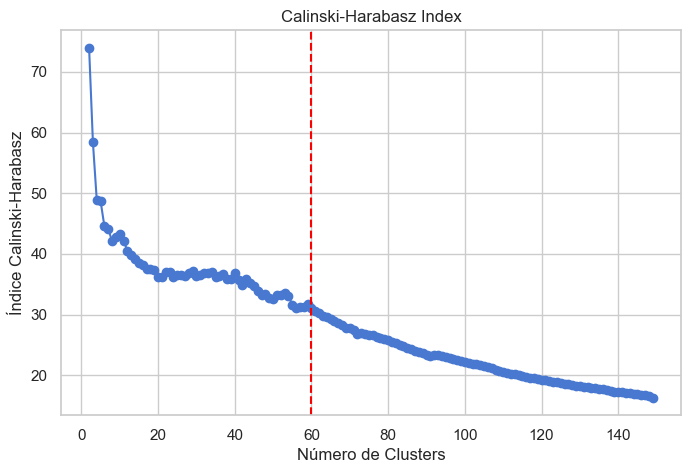

In [311]:
calinski_scores = []
for n in nb_clusters:
    kmeans = KMeans(n_clusters=n, random_state=42)
    labels = kmeans.fit_predict(data)
    calinski_scores.append(calinski_harabasz_score(data, labels))

plt.figure(figsize=(8, 5))
plt.plot(nb_clusters, calinski_scores, marker='o')
plt.axvline(x=60, color='red', linestyle='--', label="Optimal Cluster (60)")
plt.title("Calinski-Harabasz Index")
plt.xlabel("Número de Clusters")
plt.ylabel("Índice Calinski-Harabasz")
plt.grid(True)
plt.show()


### Davies-Bouldin Index

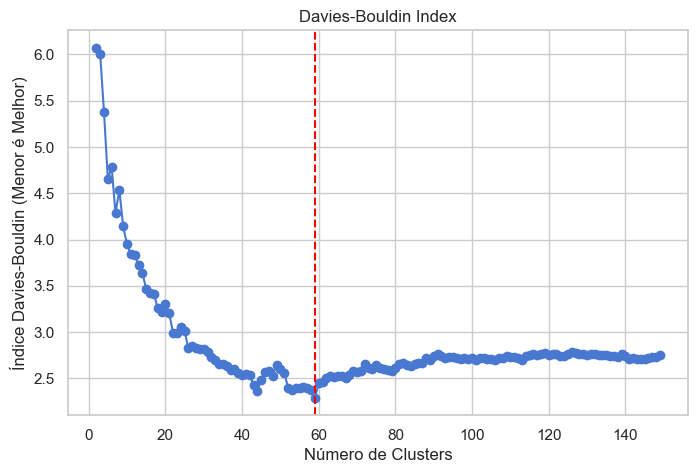

In [312]:
davies_scores = []
for n in nb_clusters:
    kmeans = KMeans(n_clusters=n, random_state=42)
    labels = kmeans.fit_predict(data)
    davies_scores.append(davies_bouldin_score(data, labels))

plt.figure(figsize=(8, 5))
plt.plot(nb_clusters, davies_scores, marker='o')
plt.axvline(x=59, color='red', linestyle='--', label="Optimal Cluster (59)")
plt.title("Davies-Bouldin Index")
plt.xlabel("Número de Clusters")
plt.ylabel("Índice Davies-Bouldin (Menor é Melhor)")
plt.grid(True)
plt.show()

### Critério de Informação de Akaike

In [313]:
aic_scores = []
for n in nb_clusters:
    gm = GaussianMixture(n_components=n, random_state=42)
    gm.fit(data)
    aic_scores.append(gm.aic(data))

plt.figure(figsize=(8, 5))
plt.plot(nb_clusters, aic_scores, marker='o')
plt.title("Critério de Informação de Akaike (AIC)")
plt.xlabel("Número de Clusters")
plt.ylabel("AIC")
plt.grid(True)
plt.show()


KeyboardInterrupt: 

### Critério de Informação Bayesiano

In [314]:
bic_scores = []
for n in nb_clusters:
    gm = GaussianMixture(n_components=n, random_state=42)
    gm.fit(data)
    bic_scores.append(gm.bic(data))

plt.figure(figsize=(8, 5))
plt.plot(nb_clusters, bic_scores, marker='o')
plt.title("Critério de Informação Bayesiano (BIC)")
plt.xlabel("Número de Clusters")
plt.ylabel("BIC")
plt.grid(True)
plt.show()


KeyboardInterrupt: 

### Conclusão

Agora que temos os resultados dos diferentes métodos para escolher o número de clusters, as orientações são:

1. **Método do Cotovelo**: Escolher o ponto onde a inércia reduz sua taxa de diminuição.
2. **Silhouette Score**: Escolher o número de clusters que maximiza a pontuação.
3. **Calinski-Harabasz Index**: Selecionar o maior valor do índice.
4. **Davies-Bouldin Index**: Selecionar o menor valor do índice.
5. **BIC (Critério de Informação Bayesiano)**: Escolher o menor valor de BIC.
6. **AIC (Critério de Informação de Akaike)**: Escolher o menor valor de AIC.

Com base nas visualizações geradas o número de clusters ideal é 60.

#### Criação e Avaliação do Modelo com K=4 e Métrica Euclidiana

Vamos criar o modelo K-Means com **K = 60** usando a métrica Euclidiana e avaliar seu desempenho.

In [315]:
selected_k = 60

# Criando o modelo K-Means
kmeans = KMeans(n_clusters=selected_k, random_state=42, n_init=10)
kmeans.fit(cluster_data_scaled)
kmeans_labels = kmeans.labels_

# Avaliando o modelo
silhouette_avg = silhouette_score(cluster_data_scaled, kmeans_labels)
calinski_harabasz = calinski_harabasz_score(cluster_data_scaled, kmeans_labels)
davies_bouldin = davies_bouldin_score(cluster_data_scaled, kmeans_labels)

print(f"K-Means com K={selected_k}:")
print(f"Silhouette Score: {silhouette_avg:.4f}")
print(f"Calinski-Harabasz Index: {calinski_harabasz:.4f}")
print(f"Davies-Bouldin Index: {davies_bouldin:.4f}")


K-Means com K=60:
Silhouette Score: 0.0968
Calinski-Harabasz Index: 30.0821
Davies-Bouldin Index: 2.2344


### Avaliação dos Resultados do K-Means com \( K = 60 \)

#### Métricas Obtidas
- **Silhouette Score**: 0.0968
- **Calinski-Harabasz Index**: 30.0821
- **Davies-Bouldin Index**: 2.2344

#### Interpretação das Métricas
1. **Silhouette Score**:
   - O valor de 0.0968, próximo de 0, indica que os clusters estão muito sobrepostos ou que a estrutura de agrupamento não é clara.
   - Valores mais próximos de 1 seriam ideais, sugerindo boa separação e coesão dos clusters.

2. **Calinski-Harabasz Index**:
   - O valor de 30.0821 é relativamente baixo, sugerindo que os clusters não são compactos ou bem separados.
   - Um índice maior é desejável, indicando melhor separação inter-cluster e menor dispersão intra-cluster.

3. **Davies-Bouldin Index**:
   - O índice de 2.2344 é relativamente alto, o que reflete clusters sobrepostos e de baixa qualidade.
   - Valores menores são preferidos, indicando melhor separação e coesão entre clusters.

#### Conclusão
Os resultados indicam que o modelo de K-Means com \( K = 60 \) não apresenta boa performance para o conjunto de dados analisado:
- Os clusters possuem baixa separação e coesão.